In [612]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
! pip install lime
import lime
from lime import lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from scipy.optimize import minimize
import gurobipy as gp
from gurobipy import GRB
import simpy as sp
import math
import warnings

# Data Generating Process

In [686]:
# DATA GENERATING CLASS

class ScalarLinearDecisionModel():
  """
    A class for generating simulated data based on our scalar linear decision model.

    Attributes:
        n_samples (int): Number of samples to generate.
        s_a_const (float): Coefficient for S in generating A (alpha).
        a_var (float): Variance for A noise (epsilon_A^2).
        a_noise (numpy.ndarray): Noise added to A based on a_var (u_A).
        s_c_const (float): Coefficient for S in generating C (omega_S).
        a_c_const (float): Coefficient for A in generating C (omega_A).
        c_var (float): Variance for C noise (epsilon_C^2).
        c_noise (numpy.ndarray): Noise added to C based on c_var (u_C).
        s_y_const (float): Coefficient for S in generating Y (m_S).
        c_y_const (float): Coefficient for C in generating Y (m_C).
        y_var (float): Variance for Y noise (epsilon_Y^2).
        y_noise (numpy.ndarray): Noise added to Y based on y_var (u_Y).
        S (numpy.ndarray): Binary variable indicating the treatment {0, 1}.
        S_sym (numpy.ndarray): Binary variable converted to {-1, 1}.
        A (numpy.ndarray): Simulated values of variable A.
        C (numpy.ndarray): Simulated values of variable C.
        Y (numpy.ndarray): Simulated values of binary outcome Y.

    Methods:
        __init__(params): Initialize the ScalarLinearDecisionModel using params, 
                          a dictionary containing model parameters.
        generate_basic_data(): Generates simulated data based on the model.
        generate_do_A_data(new_A): Generates data for improved set of ancestral featues.
        generate_improve_A_data(diff_A): Generates data by improving A by diff_A.
        generate_do_C_data(new_C): Generates data for improved set of causal featues.
        generate_improve_C_data(diff_C): Generates data by improving C by diff_C.
        ts_to_df(describe=False): Converts simulated data to a DataFrame with describe being a printer attribute.
  """
  def __init__(self, params):
    #n_samples, s_a_const = 1, a_var = 1, s_c_const = 0,  a_c_const = 1, c_var = 1, s_y_const = 1, c_y_const = 1, y_var = 0.1):
    self.n_samples = params['n_samples']
    self.s_a_const = params['s_a_const']
    self.a_var = params['a_var']
    self.a_noise = np.random.normal(loc=np.zeros(self.n_samples), scale=self.a_var*np.ones(self.n_samples))
    self.s_c_const = params['s_c_const']
    self.a_c_const = params['a_c_const']
    self.c_var = params['c_var']
    self.c_noise = np.random.normal(loc = np.zeros(self.n_samples), scale=self.c_var*np.ones(self.n_samples))
    self.s_y_const = params['s_y_const']
    self.c_y_const = params['c_y_const']
    self.y_var = params['y_var']
    #y_noise is no longer used, only bern sampling instead
    self.y_noise = np.random.normal(loc = np.zeros(self.n_samples), scale = self.y_var*np.ones(self.n_samples))
    self.S = np.random.binomial(n=1, p = 0.75, size=self.n_samples)
    #make labels s = {-1, 1} by doing (2S-1)
    self.S_sym = 2*self.S - 1
    self.A = np.empty((self.n_samples,1))
    self.C = np.empty((self.n_samples,1))
    self.Y_logit = np.empty((self.n_samples,1))
    self.Y = np.empty((self.n_samples,1))
    #self.necessary_improv = np.empty((self.n_samples, 2))
  def sigmoid(self, x):
    return 1/(1 + np.exp(-x))
  def generate_basic_data(self):
    self.A = self.S_sym*self.s_a_const + self.a_noise
    self.C = self.A*self.a_c_const + self.S_sym*self.s_c_const + self.c_noise
    self.Y_logit = self.C*self.c_y_const + self.S_sym*self.s_y_const
    self.Y = np.random.binomial(n=1, p = self.sigmoid(self.Y_logit)) #np.where(self.Y_logit > 0, 1, 0) #
  def generate_improve_data(self, S, A, diff_A, diff_C, c_noise):
    temp_A = A + diff_A
    temp_C = diff_C + (temp_A*self.a_c_const + (2*S - 1)*self.s_c_const + c_noise) 
    return temp_C#np.array([temp_A, temp_C])#
  def generate_improve_outcome(self, S, A, diff_A, diff_C, c_noise):
    temp_A = A + diff_A
    temp_C = diff_C + (temp_A*self.a_c_const + (2*S - 1)*self.s_c_const + c_noise) 
    temp_Y_logit = temp_C*self.c_y_const + (2*S - 1)*self.s_y_const
    temp_Y = np.random.binomial(n=1, p = self.sigmoid(temp_Y_logit))
    return temp_Y_logit, temp_Y
  def temp_generate_improve_data(self, diff_A, diff_C):
    temp_A = self.A+diff_A
    temp_C = temp_A*self.a_c_const + self.S_sym*self.s_c_const + self.c_noise
    temp_C += diff_C
    #temp_Y_logit = temp_C*self.c_y_const + self.S_sym*self.s_y_const + self.y_noise
    #temp_Y = np.random.binomial(n=1, p = self.sigmoid(temp_Y_logit))
    return temp_C
  def generate_do_A_data(self, new_A):
    temp_C = new_A*self.a_c_const + self.S_sym*self.s_c_const + self.c_noise
    temp_Y_logit = temp_C*self.c_y_const + self.S_sym*self.s_y_const
    temp_Y = np.where(temp_Y_logit > 0, 1, 0) #np.random.binomial(n=1, p = self.sigmoid(temp_Y_logit))
    return temp_C, temp_Y
  def generate_improve_A_data(self, diff_A):
    temp_C = (self.A+diff_A)*self.a_c_const + self.S_sym*self.s_c_const + self.c_noise
    temp_Y_logit = self.sigmoid(temp_C*self.c_y_const + self.S_sym*self.s_y_const)
    temp_Y = np.random.binomial(n=1, p = temp_Y_logit)
    return temp_C, temp_Y
  def generate_do_C_data(self, new_C):
    y_logit = self.sigmoid(new_C*self.c_y_const + self.S_sym*self.s_y_const)
    temp_Y = np.random.binomial(n=1, p = y_logit)
    return temp_Y
  def generate_improve_C_data(self, diff_C):
    y_logit = self.sigmoid((self.C+diff_C)*self.c_y_const + self.S_sym*self.s_y_const)
    temp_Y = np.random.binomial(n=1, p = y_logit)
    return temp_Y
  def ts_to_df(self, describe = False):
    sim_data = pd.DataFrame()
    sim_data["S"] = self.S
    sim_data["A"] = self.A
    sim_data["C"] = self.C
    sim_data["Y"] = self.Y
    if describe:
      print(sim_data.describe())
      print(sim_data.loc[sim_data['S'] == 0].describe())
      print(sim_data.loc[sim_data['S'] == 1].describe())
    return sim_data


# Equal Improvability

## Graph Helper Functions

In [614]:
#grapher helper functions
def line_plots(ei_data, consts, deltas, arrow_str = ''):
  """
    Generate and display line plots for Equal Improvability (EI) data.

    Args:
        ei_data (numpy.ndarray): EI data for varying cofficients and deltas.
        consts (list): List of values of the varied coefficient with which EI data was collected.
        deltas (list): List of delta values with which EI data was collected.
        arrow_str (str, optional): String for the legent to indicate the varied coefficient (default is '').
  """
  names = sorted(
            mcolors.TABLEAU_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
  names = [elem.removeprefix('tab:') for elem in names]
  for i, const in enumerate(consts):
    plt.plot(deltas, ei_data[i,:,0], color=names[i], linestyle='dashed',
             label = "protected for const = "+ str(round(const, 4)))
    plt.plot(deltas, ei_data[i,:,1], color=names[i],
             label = "not protected for const = "+ str(round(const, 4)))
  plt.xlabel('effort ($\Delta$)')
  plt.ylabel('probability of improvability')
  plt.title('Plot of P(Y(c+$\Delta$) = 1| Y(c) = 0, S = s) vs $\Delta$ effort')
  plt.legend()
  plt.show()

  for i, const in enumerate(consts):
    plt.plot(deltas, ei_data[i,:,1] - ei_data[i,:,0], color=names[i],
             label = arrow_str + " coeff = "+ str(round(const, 4)))
  plt.xlabel('effort ($\Delta$)')
  plt.ylabel('difference in probability of improving')
  plt.title('Plot of P(Y(c + $\Delta$) = 1| Y(c) = 0, S = 1) - P(Y(c + $\Delta$) = 1| Y(c) = 0, S = 0) vs $\Delta$ effort')
  plt.legend()
  plt.show()


def all_improve_heat_map_effort(results, var_I, str_var_I, var_J, str_var_J, effort_str="None", type_sim="NA", delta=0, save=False):
  """
    Generate and display a heatmap for improvement probability data across different variables.

    Args:
        results (numpy.ndarray): EI data while varying two coefficients.
        mask (numpy.ndarray): Mask to indicate missing data.
        var_I (numpy.ndarray): Array of variable values for the rows of the data, to be shown on the y-axis.
        str_var_I (str): String representation of the variable for the y-axis.
        var_J (numpy.ndarray): Array of variable values for columns of the data, to be shown on the x-axis.
        str_var_J (str): String representation of the variable for the x-axis.
        effort_str (str, optional): Description of effort regime based on delta (default is 'None').
        type_sim (str, optional): Type of experiment for the filename (default is 'NA').
        delta (float, optional): Effort change delta (default is 0).
        save (bool, optional): If True, save the generated plot (default is False).
  """
  results = np.flip(results, axis = 0)
  var_I = np.flip(var_I, axis = 0)
  if (False and np.min(results) >= 0 and np.max(results) <= 1):
    map = sns.heatmap(results, cmap='viridis', vmin=0, vmax=1)
  elif (False and np.min(results) >= -1 and np.max(results) <= 1):
    map = sns.heatmap(results, cmap='viridis', vmin=-1, vmax=1)
  else:
    map = sns.heatmap(results, cmap='viridis')
  map.set_facecolor('xkcd:black')
  #, cbar_kws={'label': 'P(Y(c + $\Delta$) = 1| Y(c) = 0, S = 0) - P(Y(c + $\Delta$) = 1| Y(c) = 0, S = 1)'})

  # Set axis labels and plot title
  plt.xlabel('Variable ' + str_var_J)
  plt.ylabel('Variable ' + str_var_I)
  plt.title("$\Delta$ = " + str(delta) + " Effort Regime")
  plt.margins(x=0)

  # Customize the tick labels on the x and y axes
  step_size_I = max(len(var_I) // 4, 1)
  step_size_J = max(len(var_J) // 4, 1)
  xtick_labels = [f'{val:.1f}' for val in var_J[::step_size_J]]
  ytick_labels = [f'{val:.1f}' for val in var_I[::step_size_I]]
  plt.xticks(np.arange(0, len(var_J), step_size_J) + 0.5, xtick_labels)
  plt.yticks(np.arange(0, len(var_I), step_size_I) + 0.5, ytick_labels)
  # Show the heatmap
  if save:
    plt.savefig("graphs/"+type_sim+"_effort_"+str(delta).replace('.', '_'))
  plt.show()


#Feature Importance Heatmaps
    
def importance_heat_map(results, var_I, str_var_I, var_J, str_var_J, title_importance="None", type_importance="NA", save=False):
  """
    Generate and display a heatmap for the importance of a single feature.

    Args:
        results (numpy.ndarray): Feature importance data.
        var_I (numpy.ndarray): Array of variable values for the rows of the data, to be shown on the y-axis.
        str_var_I (str): String representation of the variable for the y-axis.
        var_J (numpy.ndarray): Array of variable values for columns of the data, to be shown on the x-axis.
        str_var_J (str): String representation of the variable for the x-axis.
        title_importance (str, optional): Type of improvement for the title of the graph (default is 'NA').
        type_importance (str, optional): Type of experiment for the filename (default is 'None').
        save (bool, optional): If True, save the generated plot (default is False).
  """
  results = np.flip(results, axis = 0)
  var_I = np.flip(var_I, axis = 0)
  map = sns.heatmap(results, cmap='viridis')#, mask=mask)#, vmin=0, vmax=1)
  map.set_facecolor('xkcd:black')
    
  plt.xlabel('Variable ' + str_var_J)
  plt.ylabel('Variable ' + str_var_I)
  plt.title(title_importance+ " Importance")

  step_size_I = max(len(var_I) // 4, 1)
  step_size_J = max(len(var_J) // 4, 1)
  xtick_labels = [f'{val:.1f}' for val in var_J[::step_size_J]]
  ytick_labels = [f'{val:.1f}' for val in var_I[::step_size_I]]
  plt.xticks(np.arange(0, len(var_J), step_size_J) + 0.5, xtick_labels)
  plt.yticks(np.arange(0, len(var_I), step_size_I) + 0.5, ytick_labels)
  if save:
      plt.savefig("graphs/"+type_importance+"_importance")
  plt.show()

def diff_importance_heatmap(results, var_I, str_var_I, var_J, str_var_J, title_importance="None", type_importance="NA", save=False):
  """
    Generate and display a heatmap for the difference in importance of features A and C.

    Args:
        results (numpy.ndarray): Feature importance data.
        var_I (numpy.ndarray): Array of variable values for the rows of the data, to be shown on the y-axis.
        str_var_I (str): String representation of the variable for the y-axis.
        var_J (numpy.ndarray): Array of variable values for columns of the data, to be shown on the x-axis.
        str_var_J (str): String representation of the variable for the x-axis.
        title_importance (str, optional): Type of improvement for the title of the graph (default is 'NA').
        type_importance (str, optional): Type of experiment for the filename (default is 'None').
        save (bool, optional): If True, save the generated plot (default is False).
  """
  results = np.flip(results, axis = 0)
  var_I = np.flip(var_I, axis = 0)
  limit = max(np.max(results), np.min(results)*-1)
  palette = (sns.color_palette("Spectral_r", as_cmap=True))
  map = sns.heatmap(results, cmap=palette, vmin=-1*limit, vmax=limit)#, mask=mask)#, vmin=0, vmax=1)
  map.set_facecolor('xkcd:black')
  
  plt.xlabel('Variable ' + str_var_J)
  plt.ylabel('Variable ' + str_var_I)
  plt.title(title_importance+ " Importance")

  step_size_I = max(len(var_I) // 4, 1)
  step_size_J = max(len(var_J) // 4, 1)
  xtick_labels = [f'{val:.1f}' for val in var_J[::step_size_J]]
  ytick_labels = [f'{val:.1f}' for val in var_I[::step_size_I]]
  plt.xticks(np.arange(0, len(var_J), step_size_J) + 0.5, xtick_labels)
  plt.yticks(np.arange(0, len(var_I), step_size_I) + 0.5, ytick_labels)
  if save:
      plt.savefig("graphs/"+type_importance+"_importance")
  plt.show()

def categorical_heatmap(results, var_I, str_var_I, var_J,  str_var_J, type_importance="None", title_importance="NA", save=False):
  """
    Generates and displays a categorical heatmap for feature importance, i.e. when coefficient of A is greater than
    coefficient of C and vice versa.

    Args:
        results (numpy.ndarray): Feature importance data.
        var_I (numpy.ndarray): Array of variable values for the rows of the data, to be shown on the y-axis.
        str_var_I (str): String representation of the variable for the y-axis.
        var_J (numpy.ndarray): Array of variable values for columns of the data, to be shown on the x-axis.
        str_var_J (str): String representation of the variable for the x-axis.
        type_importance (str, optional): Type of experiment for the filename (default is 'None').
        title_importance (str, optional): Type of improvement for the title of the graph (default is 'NA').
        save (bool, optional): If True, save the generated plot (default is False).
  """
  results = np.flip(results, axis = 0)
  results = np.where(results < 0, -1, 1)
  var_I = np.flip(var_I, axis = 0)
  category_cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
    
  sns.heatmap(results, fmt='', cmap=sns.color_palette("Spectral_r", as_cmap=True), cbar_kws={"ticks": [-1, 0, 1]},
               vmin=-1.25, vmax=1.25)

  plt.xlabel('Variable ' + str_var_J)
  plt.ylabel('Variable ' + str_var_I)
  plt.title(type_importance)
  step_size_I = max(len(var_I) // 4, 1)
  step_size_J = max(len(var_J) // 4, 1)
  xtick_labels = [f'{val:.1f}' for val in var_J[::step_size_J]]
  ytick_labels = [f'{val:.1f}' for val in var_I[::step_size_I]]
  plt.xticks(np.arange(0, len(var_J), step_size_J) + 0.5, xtick_labels)
  plt.yticks(np.arange(0, len(var_I), step_size_I) + 0.5, ytick_labels)
  if save:
    plt.savefig("graphs/"+type_importance+"_pos_importance")
  plt.show()


## Optimization Helper Functions

In [659]:
def find_pred_improve_lin_cost(dt, cost_fn, pred_fn, data):
  """
    Find the best improvement for each individual in the dataset considering cost constraints.

    Args:
        cost_fn (dict): Cost function with weights and bias.
        pred_fn (dict): Prediction function with weights and bias.
        data (dict): Dictionary containing data of sensitive features, S, and observed features, A and C,
        that the predictor observed.

    Returns:
        numpy.ndarray: Array of the necessary cost improvements for each individual.
  """
  features = data["AC"]
  n, d = features.shape
  best_improvement = np.zeros_like(features)
  which_improve = np.zeros(n)
  delta_necessary = np.zeros(n)
  for individual in range(n):
    try:
      model = gp.Model("best_improvement")
      model.Params.LogToConsole = 0
      improve_vector = model.addMVar(shape=(1,d), name="added_vector")
      #improve_A = model.addVar(lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="improve_A")
      #improve_C = model.addVar(lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="improve_C")
      #improve_vector = np.array([improve_A, improve_C])
      #print(improve_vector.shape)
      temp_C = dt.generate_improve_data(S = data['S'][individual], A = features[individual][0], diff_A = improve_vector[:, 0], 
                                        diff_C = improve_vector[:, 1], c_noise = data['c_noise'][individual])
      improved_features = np.array([improve_vector[:, 0] + features[individual][0], temp_C])
      #print(improved_features)
      model.setObjective(improve_vector@cost_fn['w'] + cost_fn['b'], GRB.MINIMIZE)
      # Add the constraint for less than delta cost
      model.addConstr((improved_features)@pred_fn['w'] + pred_fn['b'] >= 0.0000001)
      #model.addConstr( <= delta)
       # Optimize the model
      model.optimize()
      # Get the optimal solution
      if model.status == GRB.OPTIMAL:
        best_improvement[individual] = improve_vector.X
        #print(model.getObjective().getValue())
        delta_necessary[individual] = model.getObjective().getValue()

    except gp.GurobiError as e:
      print("Error code " + str(e.errno) + ": " + str(e))
    #print("solved!")
    #print(best_improvement[individual, 0])
    #print(np.sign(best_improvement[individual, 0] - best_improvement[individual, 1]))
    which_improve[individual] = np.sign(best_improvement[individual, 0] - best_improvement[individual, 1])
    #print(which_improve.shape)
    #print(which_improve[individual])
  return delta_necessary, best_improvement, which_improve


def find_real_improve_lin_cost(dt, cost_fn, data):
  """
    Find the best improvement for each individual in the dataset considering cost constraints.

    Args:
        cost_fn (dict): Cost function with weights and bias.
        pred_fn (dict): Prediction function with weights and bias.
        data (dict): Dictionary containing data of sensitive features, S, and observed features, A and C,
        that the predictor observed.

    Returns:
        numpy.ndarray: Array of the necessary cost improvements for each individual.
  """
  features = data["AC"]
  n, d = features.shape
  best_improvement = np.zeros_like(features)
  which_improve = np.zeros(n)
  delta_necessary = np.zeros(n)
  for individual in range(n):
    try:
      model = gp.Model("best_improvement")
      model.Params.LogToConsole = 0
      improve_vector = model.addMVar(shape=(1,d), name="added_vector")
      #improve_A = model.addVar(lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="improve_A")
      #improve_C = model.addVar(lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="improve_C")
      #improve_vector = np.array([improve_A, improve_C])
      #print(improve_vector.shape)
      temp_C = dt.generate_improve_data(S = data['S'][individual], 
                                        A = features[individual][0], 
                                        diff_A = improve_vector[:, 0], 
                                        diff_C = improve_vector[:, 1], 
                                        c_noise = data['c_noise'][individual])
      improved_features = np.array([improve_vector[:, 0] + features[individual][0], temp_C])
      #print(improved_features)
      model.setObjective(improve_vector@cost_fn['w'] + cost_fn['b'], GRB.MINIMIZE)
      # Add the constraint for less than delta cost
      model.addConstr(temp_C*dt.c_y_const + (2*data['S'][individual] - 1)*dt.s_y_const >= 0.0000001)
      #model.addConstr( <= delta)
       # Optimize the model
      model.optimize()
      # Get the optimal solution
      if model.status == GRB.OPTIMAL:
        best_improvement[individual] = improve_vector.X
        #print(model.getObjective().getValue())
        delta_necessary[individual] = model.getObjective().getValue()

    except gp.GurobiError as e:
      print("Error code " + str(e.errno) + ": " + str(e))
    #print("solved!")
    #print(best_improvement[individual, 0])
    #print(np.sign(best_improvement[individual, 0] - best_improvement[individual, 1]))
    which_improve[individual] = np.sign(best_improvement[individual, 0] - best_improvement[individual, 1])
    #print(which_improve.shape)
    #print(which_improve[individual])
  return delta_necessary, best_improvement, which_improve

## GRAPH HELPERS

## Fairness Metrics Function

In [721]:
def new_fairness_violation(trainer, trials, params, deltas, cost_fn, str_var_1, vars_1, str_var_2, vars_2):
  """
    Calculate new proposed metrics related to Equal Improvability (EI) measure, varying two parameters 
    in order to make heatmaps using optimization.

    Args:
        trainer: The trained model used for prediction.
        trials (int): Number of trials to simulate to collect data.
        params (dict): Parameters for the data generation model.
        deltas (numpy.ndarray): Array of different effort change, delta.
        cost_fn (dict): Cost function with weights and bias.
        str_var_1 (str): String representing the variable name for the first coefficient that is varied.
        vars_1 (numpy.ndarray): Array of variable values to be used to vary the first coefficient.
        str_var_2 (str): String representing the variable name for the second coefficient that is varied.
        vars_2 (numpy.ndarray): Array of variable values to be used to vary the second coefficient.

    Returns:
        dict: A dictionary containing the following calculated metrics:
            - gaming: Array containing the gaming metric for each set of different parameters. 
            - improve_data: Array containing the improvement metric for each set of different parameters.
            - mask: Mask indicating missing data.
            - best_feature_improved: Array of 1 where C was better to improve -1 where A was better improve, and 0 if equal.
            - pred_accuracy: Array of prediction accuracy for each set of parameters.
            - feature_weights_AC: Array of feature weights for each set of parameters.
  """
  ei_data = np.zeros((trials, deltas.shape[0], vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  improve_data = np.zeros((trials, deltas.shape[0], vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  gaming_data = np.zeros((trials, deltas.shape[0], vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  improvable_labels = np.zeros((trials, deltas.shape[0], vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  pred_delta_too_high = np.zeros((trials, deltas.shape[0], vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  pred_accuracy = np.zeros((trials, vars_1.shape[0], vars_2.shape[0]))*np.nan
  pred_feature_weights = np.zeros((trials, 2, vars_1.shape[0], vars_2.shape[0]))*np.nan
  pred_feature_improved = np.zeros((trials, vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  real_feature_improved = np.zeros((trials, vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  pred_delta_improv = np.zeros((trials, vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  real_delta_improv = np.zeros((trials, vars_1.shape[0], vars_2.shape[0], 2))*np.nan
  for i, var_1 in enumerate(vars_1):
    for j, var_2 in enumerate(vars_2):
      for trial in range(trials):
        #Generate Data
        params[str_var_1] = var_1
        params[str_var_2] = var_2
        data_train = ScalarLinearDecisionModel(params)
        data_train.generate_basic_data()
        data_train_AC = np.concatenate((data_train.A.reshape((data_train.n_samples,1)), data_train.C.reshape((data_train.n_samples,1))), axis=1)
        model = trainer.fit(data_train_AC, data_train.Y)
        #data_test = ScalarLinearDecisionModel(params)
        #data_test.generate_basic_data()
        data_summary = {
            "c_noise": data_train.c_noise,
            "S": data_train.S,
            "AC": np.concatenate((data_train.A.reshape((data_train.n_samples,1)), data_train.C.reshape((data_train.n_samples,1))), axis=1),
            "Y_logit": data_train.Y_logit,
            "Y": data_train.Y
        }
        pred_y = model.predict(data_summary["AC"])
        pred_accuracy[trial, i, j] = model.score(data_summary["AC"], data_summary["Y"])
        pred_feature_weights[trial, :, i, j] = (model.coef_[0])
        pred_fn = {'w': model.coef_.flatten(), 'b': model.intercept_[0]} 
        #if we have some unqualified majority members, we can collect data
        if len(data_summary['S'][(data_summary['S'] == 1) & (data_summary['Y'] == 0)]) == 0:
          print("FAILED trial: ", trial, " with var 1: ", var_1, " and var 2: ", var_2)
        else:
          #print("SUCCEEDED trial: ", trial, " with var 1: ", var_1, " and var 2: ", var_2)
          pred_best_delta, pred_best_improvement, pred_which_improve = find_pred_improve_lin_cost(data_train, cost_fn, pred_fn, data_summary)
          real_best_delta, real_best_improvement, real_which_improve = find_best_real_improve_lin_cost(data_train, cost_fn, data_summary)
          pred_delta_improv[trial, i, j, 0] = np.mean(pred_best_delta[data_summary["S"] == 0])
          pred_delta_improv[trial, i, j, 1] = np.mean(pred_best_delta[data_summary["S"] == 1])
          real_delta_improv[trial, i, j, 0] = np.mean(real_best_delta[data_summary["S"] == 0])
          real_delta_improv[trial, i, j, 1] = np.mean(real_best_delta[data_summary["S"] == 1])
          pred_feature_improved[trial, i, j, 0] = np.mean(pred_which_improve[data_summary["S"] == 0])
          pred_feature_improved[trial, i, j, 1] = np.mean(pred_which_improve[data_summary["S"] == 1])
          real_feature_improved[trial, i, j, 0] = np.mean(real_which_improve[data_summary["S"] == 0])
          real_feature_improved[trial, i, j, 1] = np.mean(real_which_improve[data_summary["S"] == 1])
            
          for d, delta in enumerate(deltas):
            #print((pred_best_delta-real_best_delta)[(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)][data_summary['S'][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)] == 0])
            
            #Collect average number of people who needed less than delta in reality but needed more than delta for the prediction
            pred_delta_too_high[trial, d, i, j, 0] = np.mean(np.where((real_best_delta[data_summary['S'] == 0] <= delta) & (pred_best_delta[data_summary['S'] == 0] > delta), 1, 0))
            pred_delta_too_high[trial, d, i, j, 1] = np.mean(np.where((real_best_delta[data_summary['S'] == 1] <= delta) & (pred_best_delta[data_summary['S'] == 1] > delta), 1, 0))
            
            #Collect avgerage label of improvable people without the improvement
            improvable_labels[trial, d, i, j, 0] = np.mean(pred_y[(pred_best_delta <= delta) & (data_summary["S"] == 0)])
            improvable_labels[trial, d, i, j, 1] = np.mean(pred_y[(pred_best_delta <= delta) & (data_summary["S"] == 1)])
            
            #Collect EI data: P(f_hat(x + delta_hat_x) >= 0.5 | f_hat(x) < 0.5)
            f_results_ei =  np.where(pred_best_delta[pred_y == 0] <= delta, 1, 0)
            
            ei_data[trial, d, i, j, 0] = np.mean(f_results_ei[data_summary["S"][pred_y == 0] == 0])
            ei_data[trial, d, i, j, 1] = np.mean(f_results_ei[data_summary["S"][pred_y == 0] == 1])
            
            #Collect Gaming data: P(f_hat(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_hat_x) < 0.5 )
            pred_best_improvement_delta = np.zeros_like(pred_best_improvement)
            pred_best_improvement_delta[pred_best_delta <= delta] = pred_best_improvement[pred_best_delta <= delta]
            f_results_g, _ = data_train.generate_improve_outcome(S = data_summary['S'][data_summary['Y_logit'] < 0], 
                                                        A = data_summary['AC'][data_summary['Y_logit'] < 0][:, 0],
                                                        diff_A = pred_best_improvement_delta[data_summary['Y_logit'] < 0][:, 0], 
                                                        diff_C = pred_best_improvement_delta[data_summary['Y_logit'] < 0][:, 1], 
                                                        c_noise = data_summary['c_noise'][data_summary['Y_logit'] < 0])
            
            #filtered_pred_improvement = pred_best_improvement_delta[f_results_g == 0]
            gaming_pred = np.where(pred_best_delta[data_summary['Y_logit'] < 0][f_results_g < 0] <= delta,1,0)
            #gaming_pred = model.predict(data_unqualified['AC'][f_results_g == 0] + filtered_pred_improvement[f_results_g == 0])
            filtered_S_g = data_summary['S'][data_summary['Y_logit'] < 0][f_results_g < 0]
            #print(np.mean(f_results_g))
            #print(np.mean(gaming_pred))
            gaming_data[trial, d, i, j, 0] = np.mean(gaming_pred[filtered_S_g == 0])
            gaming_data[trial, d, i, j, 1] = np.mean(gaming_pred[filtered_S_g == 1])
            
            # Collect Improvment data: P(f(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_x) >= 0.5)
            filtered_S_i = data_summary['S'][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)]
            f_results_i, _ = data_train.generate_improve_outcome(S = filtered_S_i, 
                                                        A = data_summary['AC'][:, 0][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)],
                                                        diff_A = pred_best_improvement[:, 0][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)], 
                                                        diff_C = pred_best_improvement[:, 1][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)], 
                                                        c_noise = data_summary['c_noise'][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)])
            improv_results = np.where(f_results_i >= 0, 1, 0)  
            #print(pred_best_improvement[(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)][filtered_S_i == 0])
            #print(data_summary['Y_logit'][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)][filtered_S_i == 0] - f_results_i[filtered_S_i == 0] )
            improve_data[trial, d, i, j, 0] = np.mean(improv_results[filtered_S_i == 0])
            improve_data[trial, d, i, j, 1] = np.mean(improv_results[filtered_S_i == 1])
            
         
      #print("var 1: ", var_1, " and var 2: ", var_2)   
  results = {
      "ei_data": np.where(np.isnan(ei_data).sum(axis=0) < ei_data.shape[0]*3/4, np.nanmean(ei_data, axis=0), np.nan), 
      "gaming_data": np.where(np.isnan(gaming_data).sum(axis=0) < gaming_data.shape[0]*3/4, np.nanmean(gaming_data, axis=0), np.nan), 
      "improve_data": np.where(np.isnan(improve_data).sum(axis=0) < improve_data.shape[0]*3/4, np.nanmean(improve_data, axis=0), np.nan),  
      "pred_accuracy": np.where(np.isnan(pred_accuracy).sum(axis=0) < pred_accuracy.shape[0]*3/4, np.nanmean(pred_accuracy, axis=0), np.nan), 
      "pred_feature_weights": np.where(np.isnan(pred_feature_weights).sum(axis=0) < pred_feature_weights.shape[0]*3/4, np.nanmean(pred_feature_weights, axis=0), np.nan),
      "pred_feature_improved": np.where(np.isnan(pred_feature_improved).sum(axis=0) < pred_feature_improved.shape[0]*3/4, np.nanmean(pred_feature_improved, axis=0), np.nan), 
      "real_feature_improved": np.where(np.isnan(real_feature_improved).sum(axis=0) < real_feature_improved.shape[0]*3/4, np.nanmean(real_feature_improved, axis=0), np.nan),
      "pred_delta_improv": np.where(np.isnan(pred_delta_improv).sum(axis=0) < pred_delta_improv.shape[0]*3/4, np.nanmean(pred_delta_improv, axis=0), np.nan),
      "real_delta_improv": np.where(np.isnan(real_delta_improv).sum(axis=0) < real_delta_improv.shape[0]*3/4, np.nanmean(real_delta_improv, axis=0), np.nan),
      "improvable_labels": np.where(np.isnan(improvable_labels).sum(axis=0) < improvable_labels.shape[0]*3/4, np.nanmean(improvable_labels, axis=0), np.nan),
      "pred_delta_too_high": np.where(np.isnan(pred_delta_too_high).sum(axis=0) < pred_delta_too_high.shape[0]*3/4, np.nanmean(pred_delta_too_high, axis=0), np.nan)
  }
  return results




# CURRENT RUNS

In [738]:
default_params = {
    'n_samples': 1000, 
    's_a_const': 1, 
    'a_var': 1, 
    's_c_const': 0,  
    'a_c_const': 1, 
    'c_var': 1, 
    's_y_const': 1, 
    'c_y_const': 1, 
    'y_var': 0.1 
}

In [ ]:
simulation_gaming = {
  "trials": 5,
  "consts_sa": np.arange(0, 2, 0.1),
  "consts_ac": np.arange(0, 2, 0.1),
  "deltas": np.array([0.1, 0.25, 0.5, 1, 2, 2.5, 5]),
  "type_effort": ["Lowest", "Low", "Mid-Low", "Mid", "High", "Higher", "Highest"],
  "type_sims": ["test_A_", "test_C_", "test_AC_"],
  "imprtnc_type_sims": ["test_A", "test_C", "test_Difference_between_A_and_C", "test_Improve_A_or_C"],
  "imprtnc_title_sims": ["A", "C", "Difference between A and C", "Categorical Heatmap of A vs. C Importance"]
}

gaming_params = default_params.copy()


cost_fn ={'w': np.array([1, 1]),'b': 0}

with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")
  warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in double_scalars")

  testing = new_fairness_violation(LogisticRegression(), simulation_gaming["trials"], 
                               params = gaming_params,
                               deltas = simulation_gaming["deltas"], 
                               cost_fn = cost_fn,
                               str_var_1 = 's_a_const',
                               vars_1 = simulation_gaming["consts_sa"], 
                               str_var_2 = 'a_c_const',
                               vars_2 = simulation_gaming["consts_ac"])


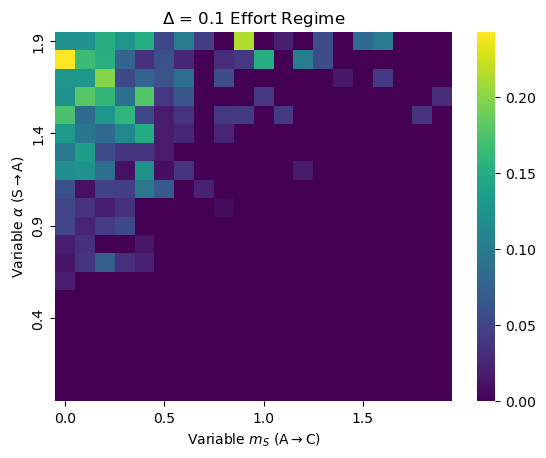

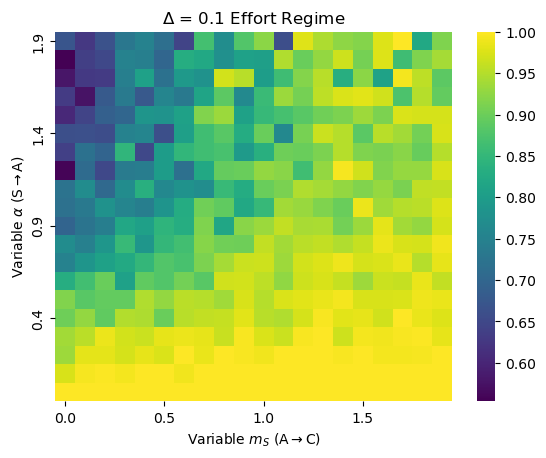

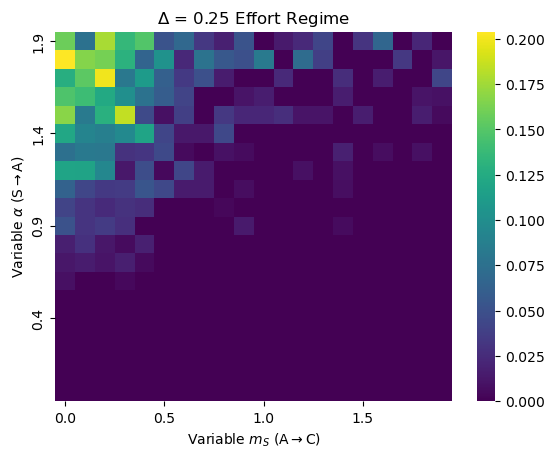

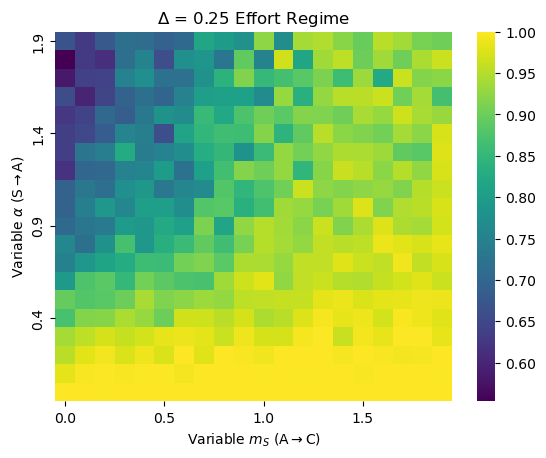

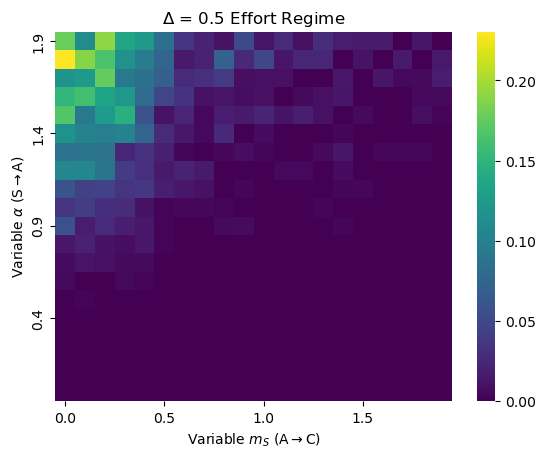

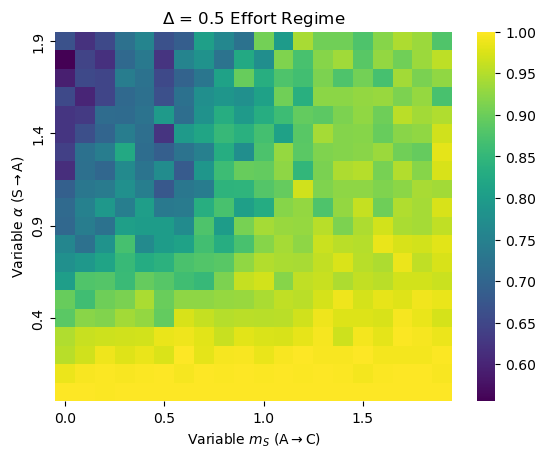

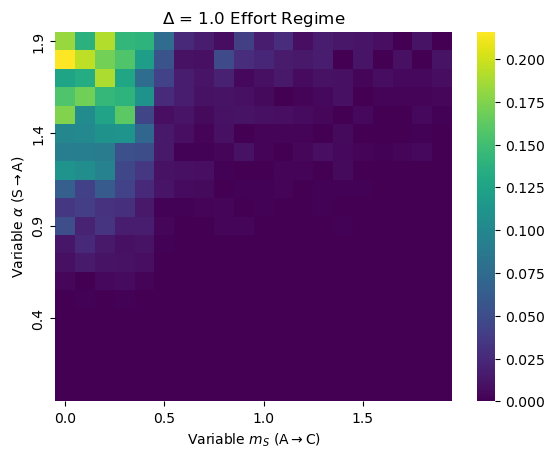

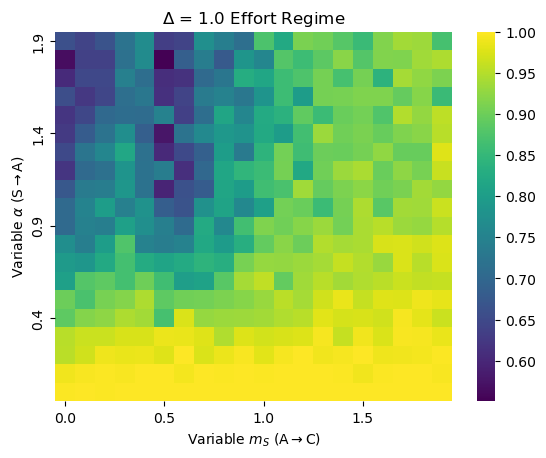

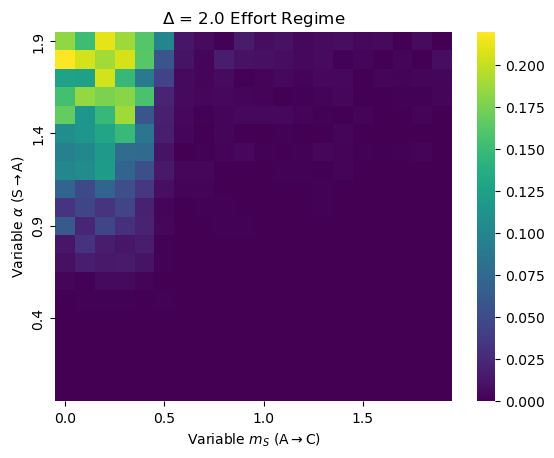

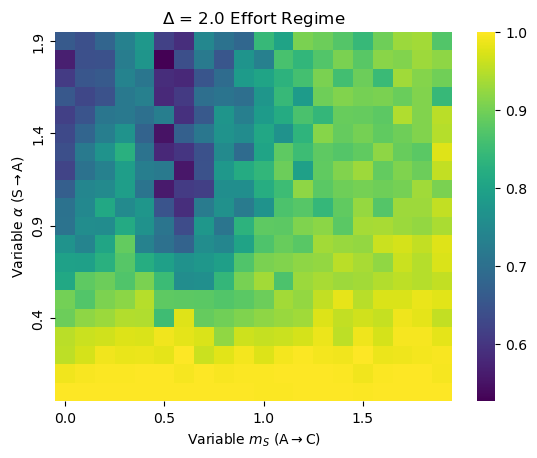

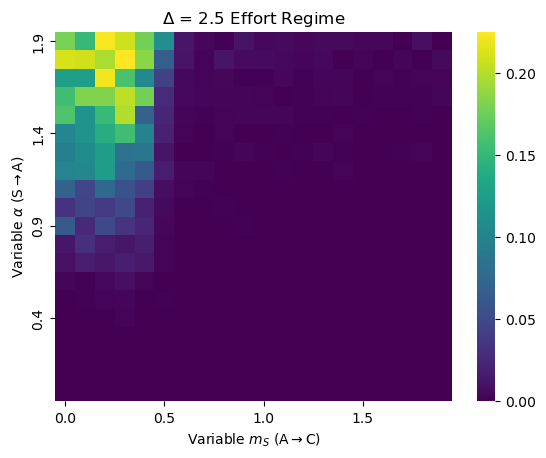

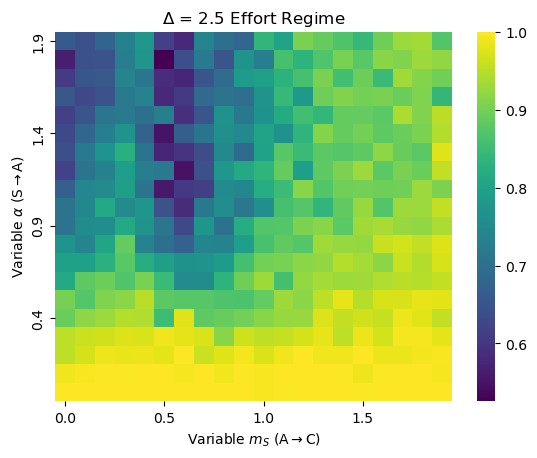

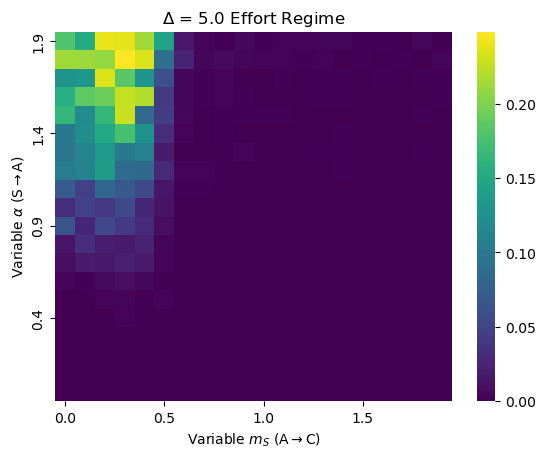

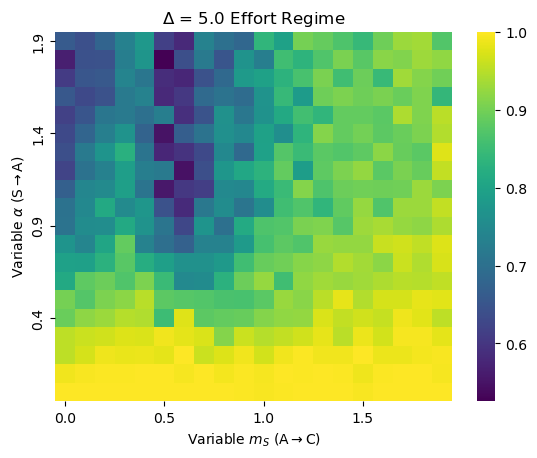

In [725]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["improve_data"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_0", delta, save=True)
  all_improve_heat_map_effort(ei_data_test["improve_data"][d][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_1", delta, save=True)

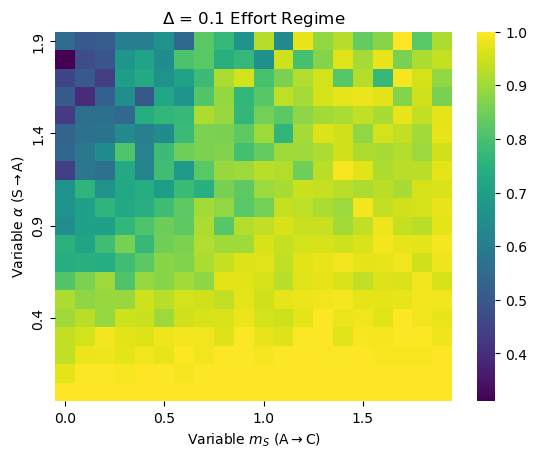

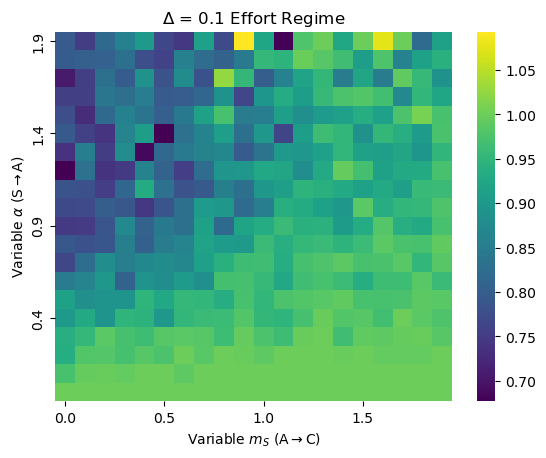

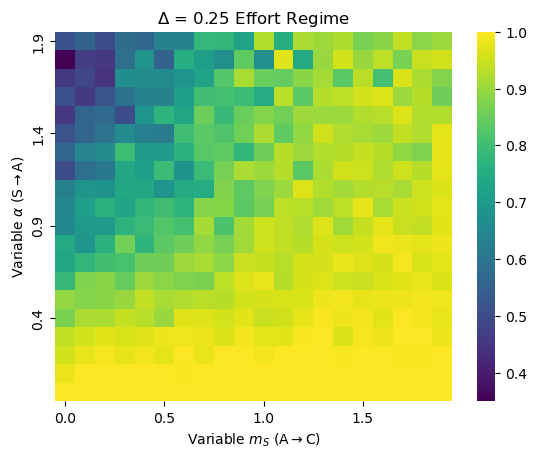

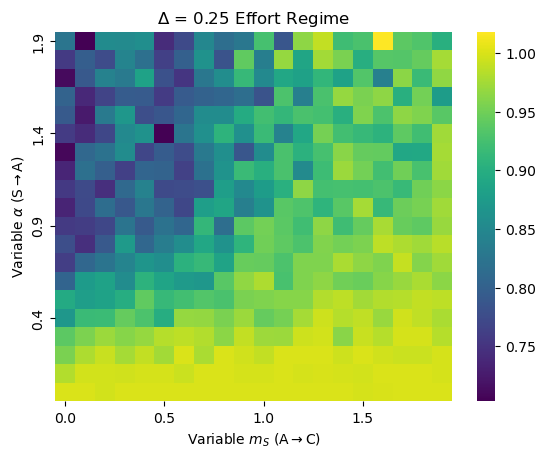

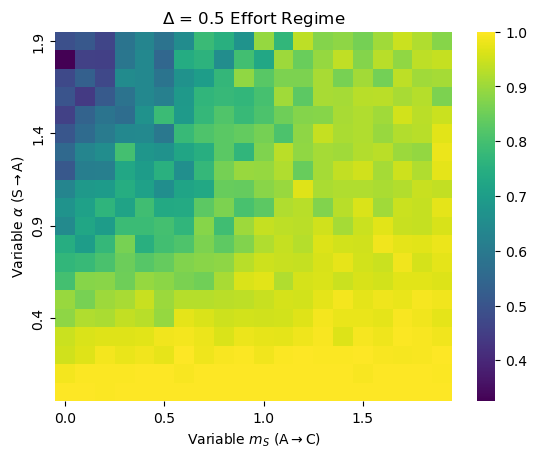

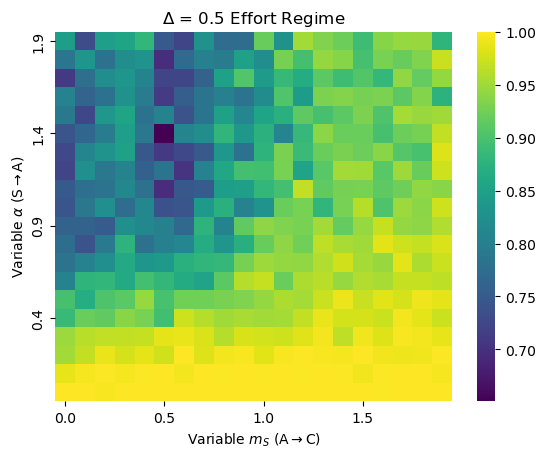

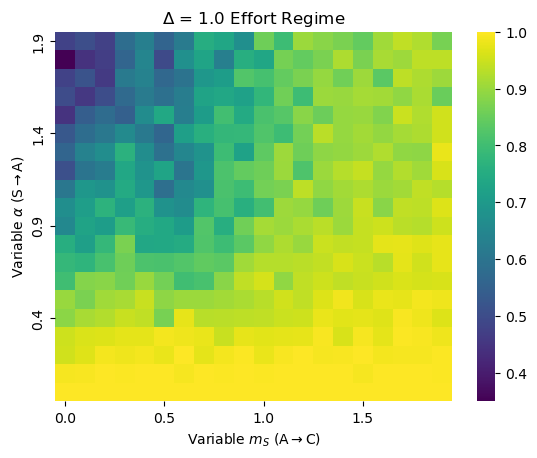

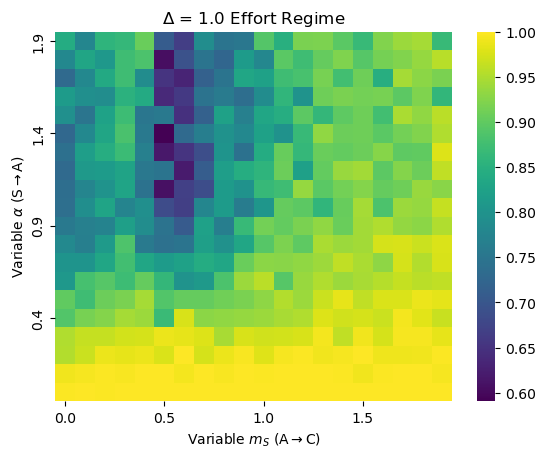

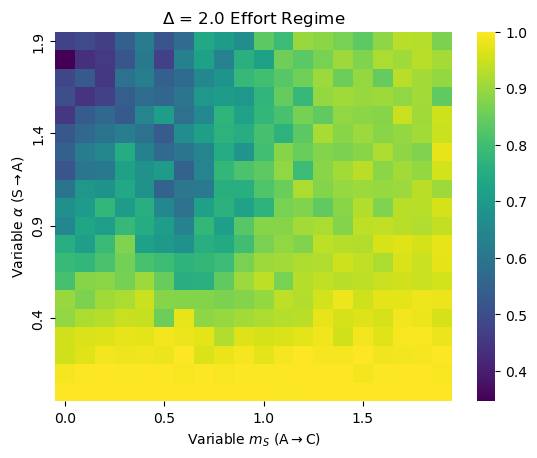

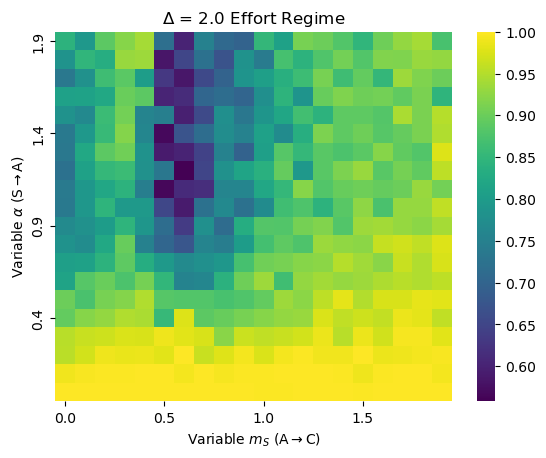

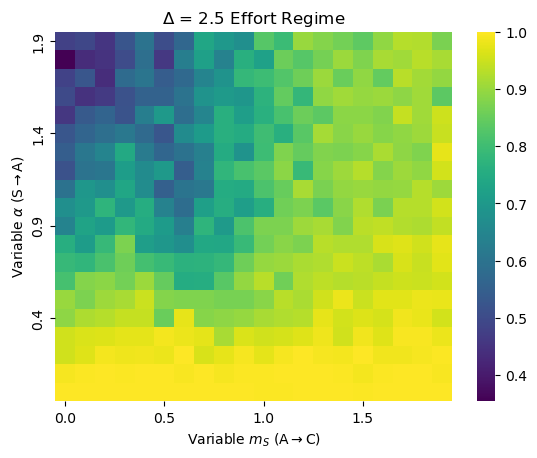

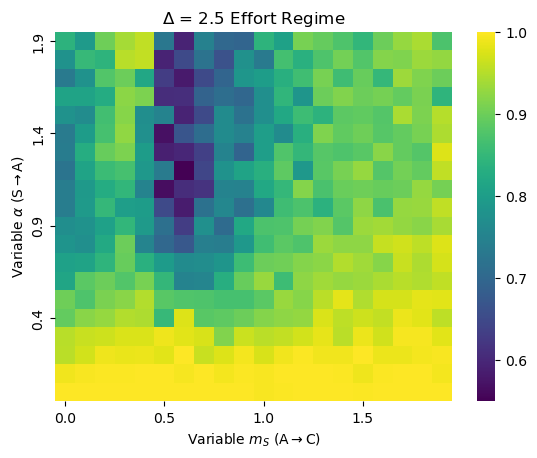

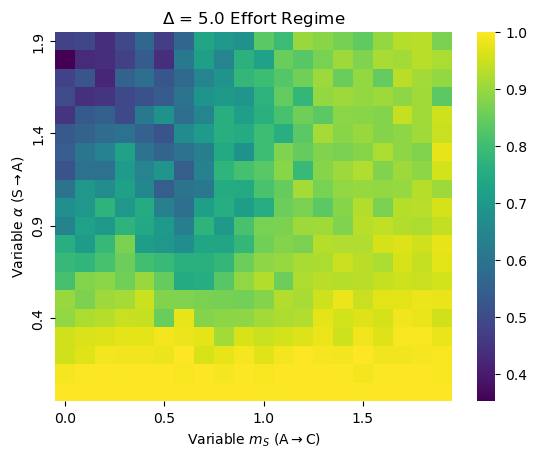

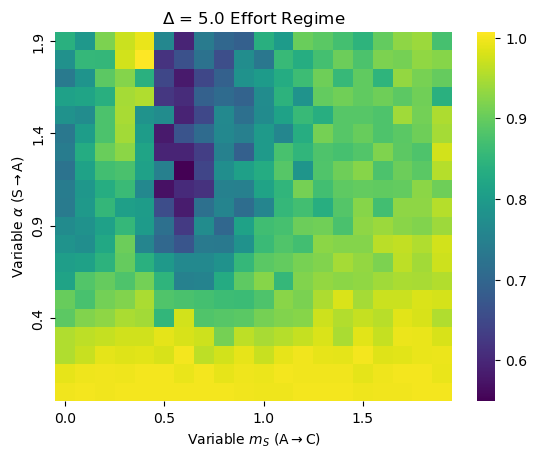

In [726]:
 #DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["improve_data"][d][:,:,1] - ei_data_test["improve_data"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_0", delta, save=True)
  all_improve_heat_map_effort(ei_data_test["improve_data"][d][:,:,1] + ei_data_test["improve_data"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_1", delta, save=True)

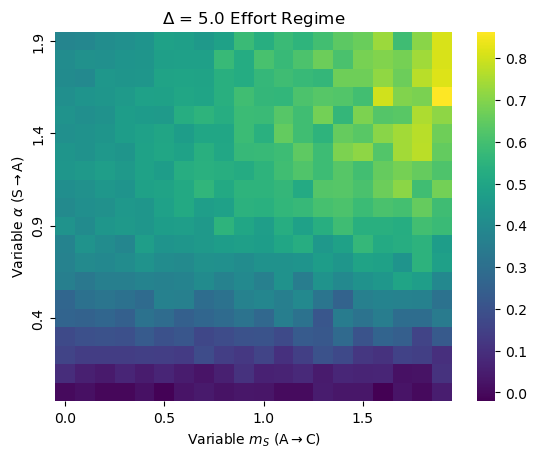

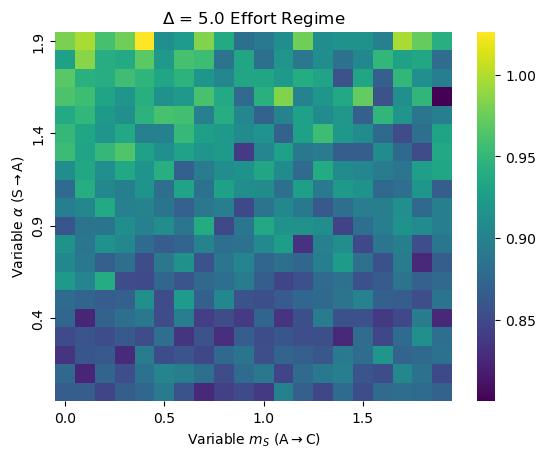

In [729]:
#print(ei_data_test["pred_feature_weights"][0])
all_improve_heat_map_effort(ei_data_test["pred_feature_weights"][0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "Improvement_diff", delta)

all_improve_heat_map_effort(ei_data_test["pred_feature_weights"][1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "Improvement_diff", delta)

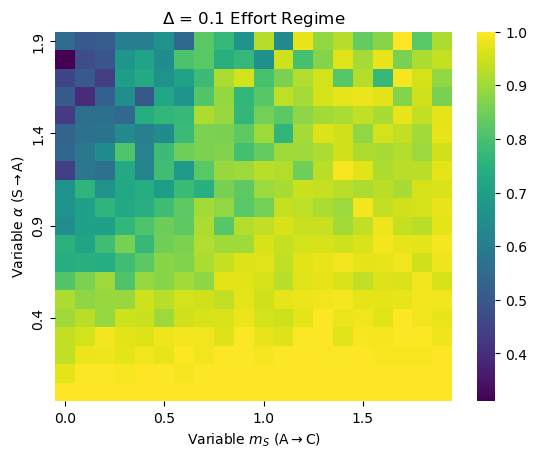

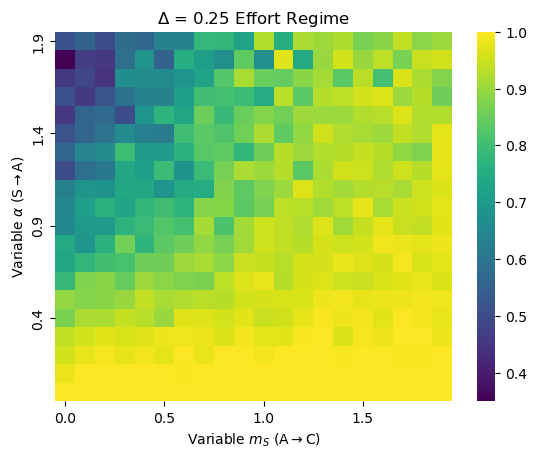

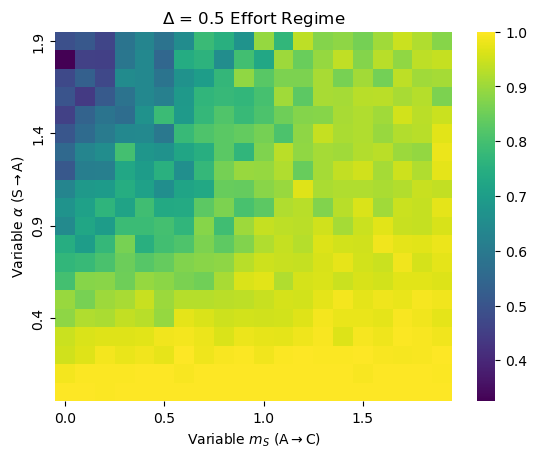

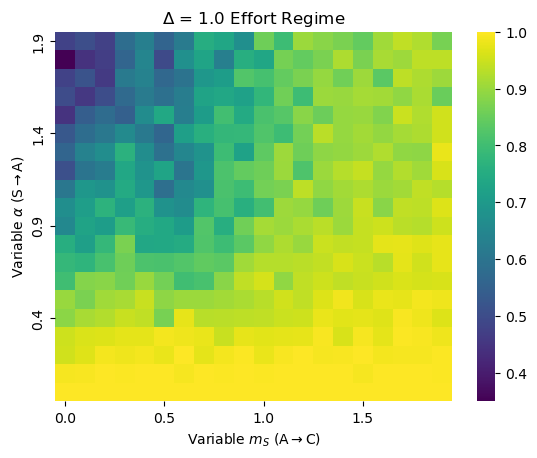

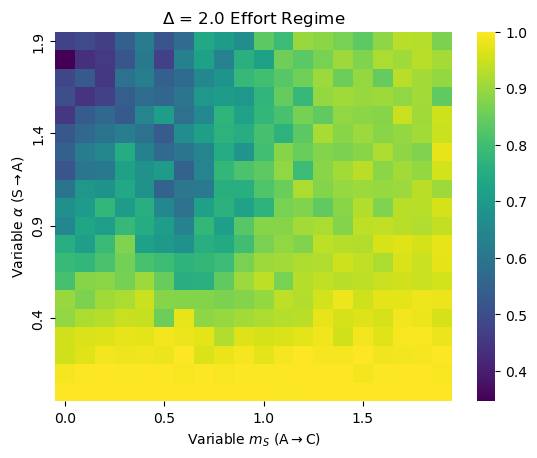

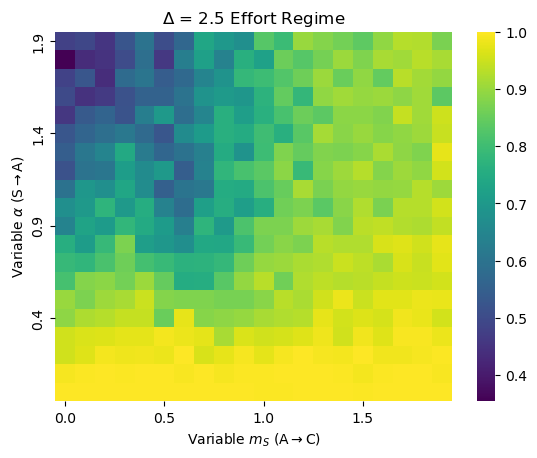

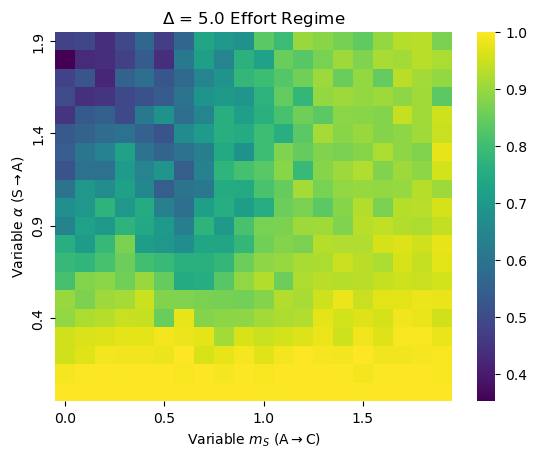

In [730]:
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["improve_data"][d][:,:,1]- ei_data_test["improve_data"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_diff", delta, save=True)
  

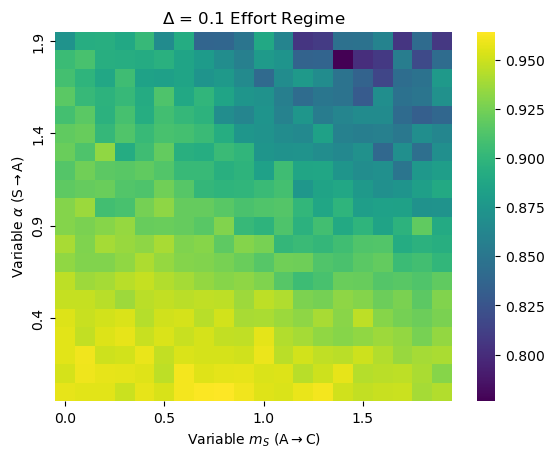

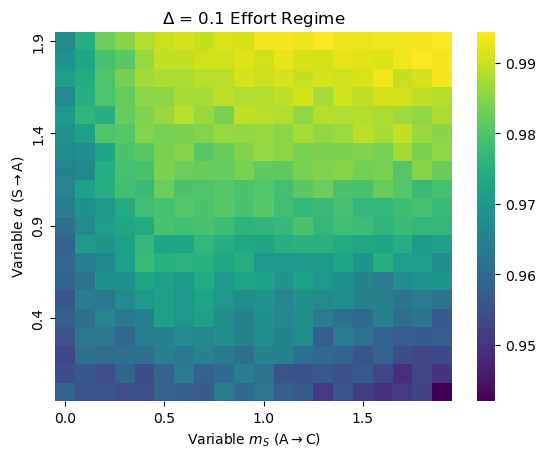

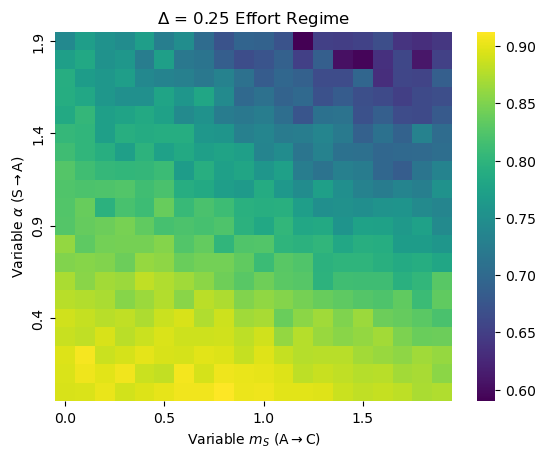

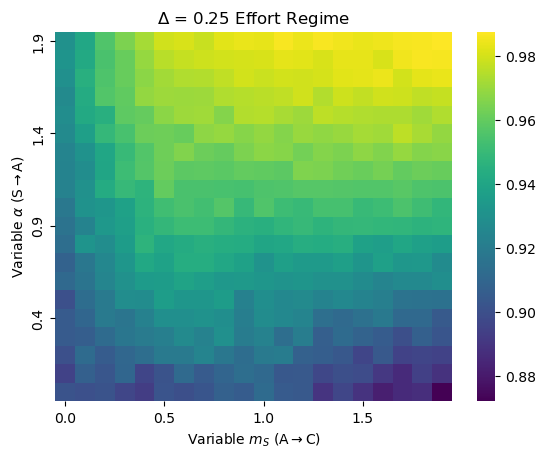

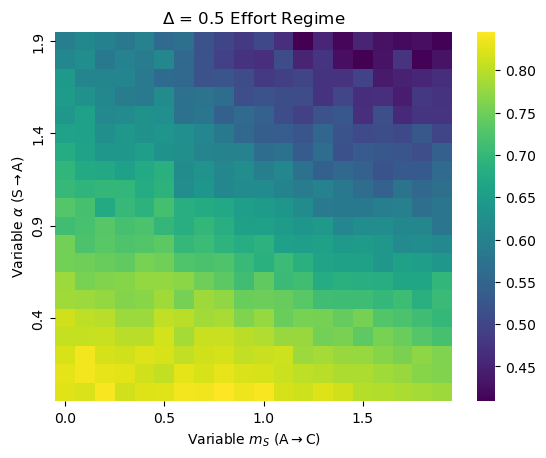

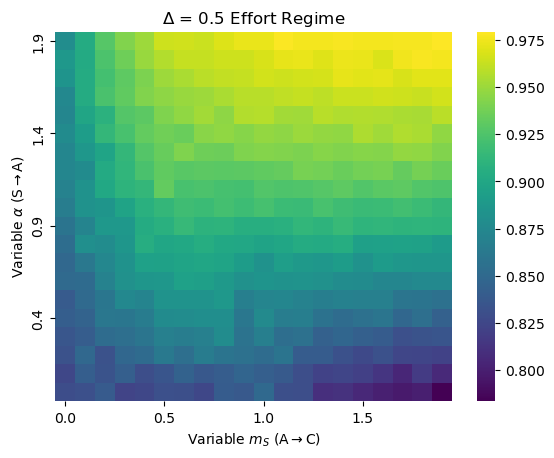

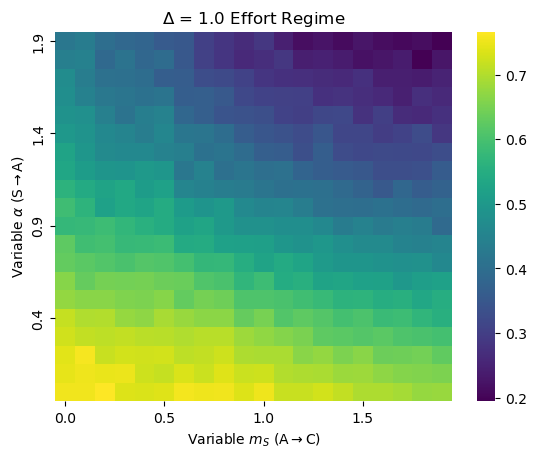

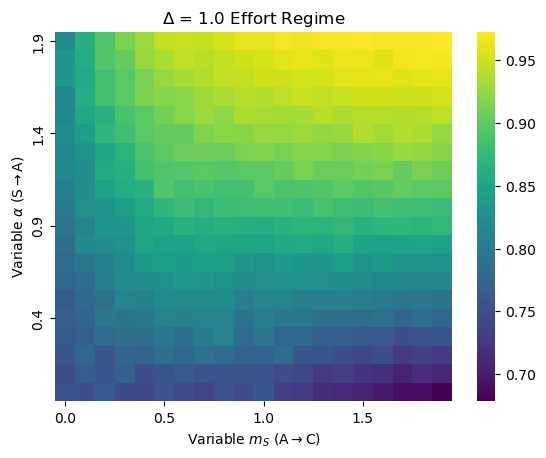

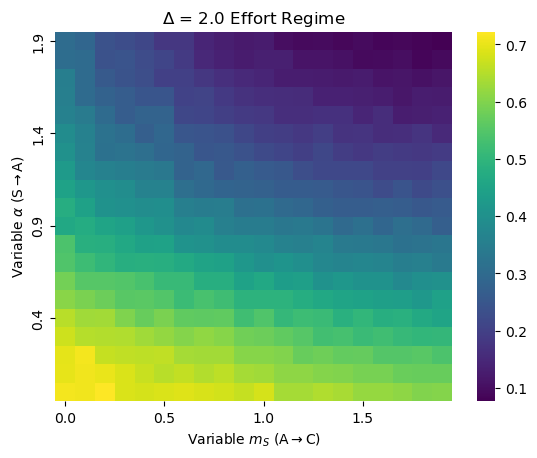

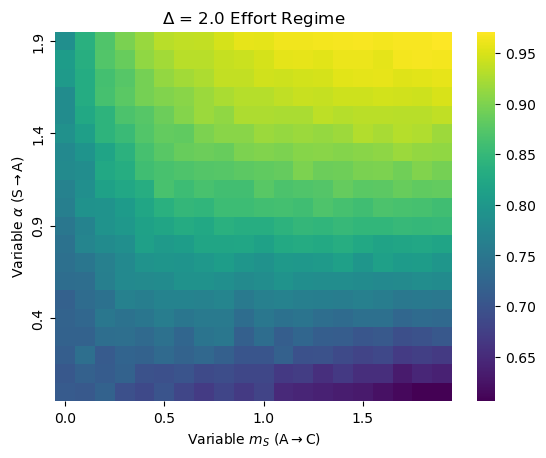

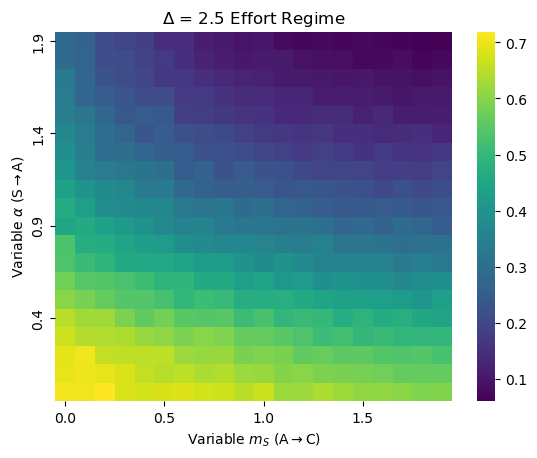

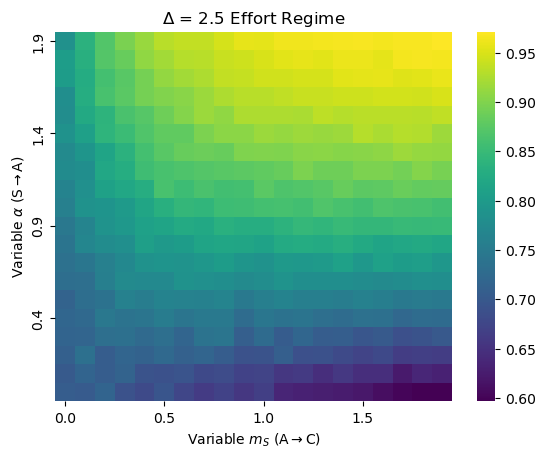

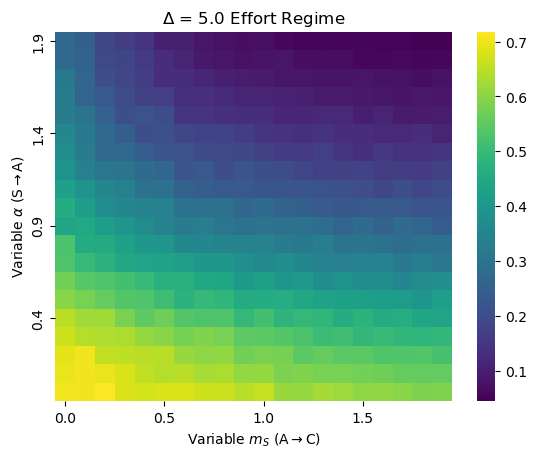

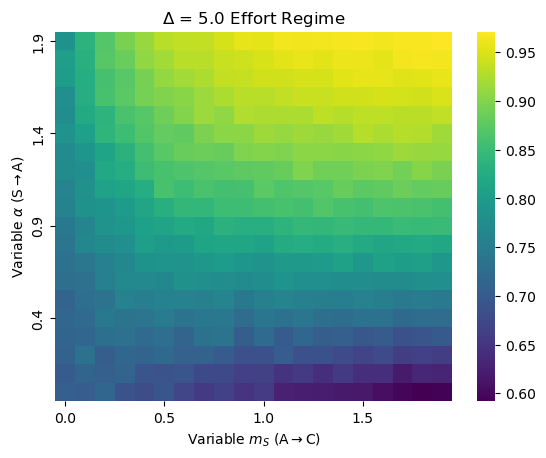

In [731]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["improvable_labels"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_0", delta)
  all_improve_heat_map_effort(ei_data_test["improvable_labels"][d][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_1", delta)

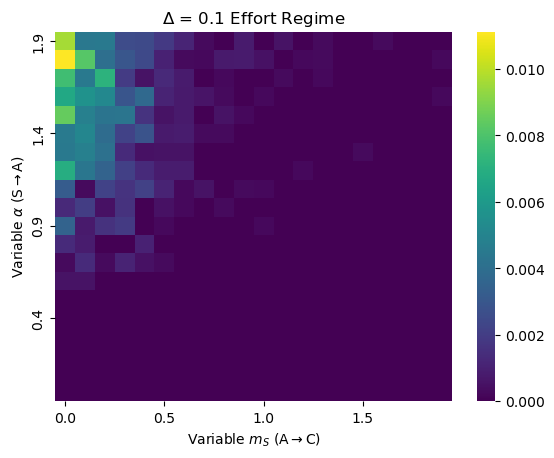

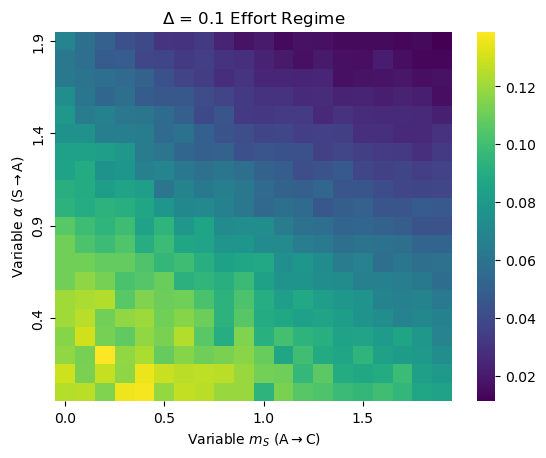

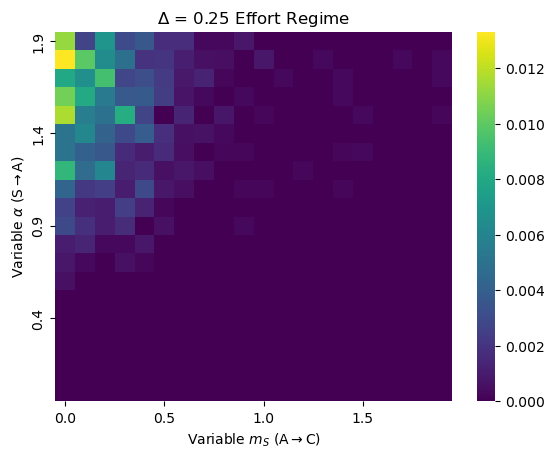

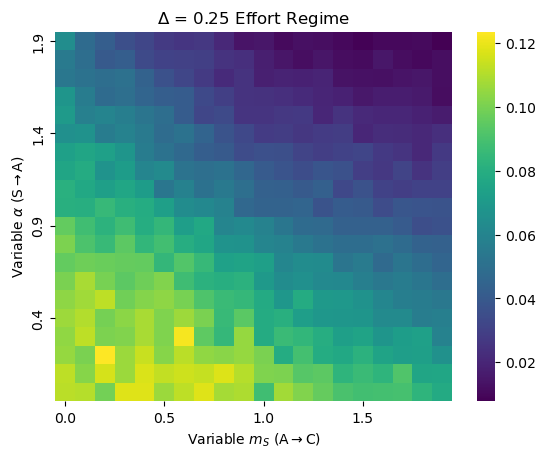

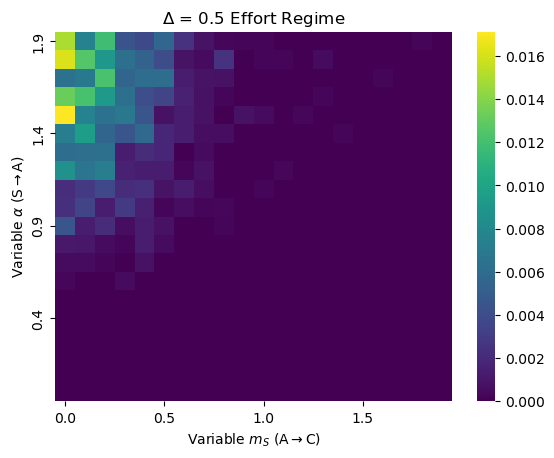

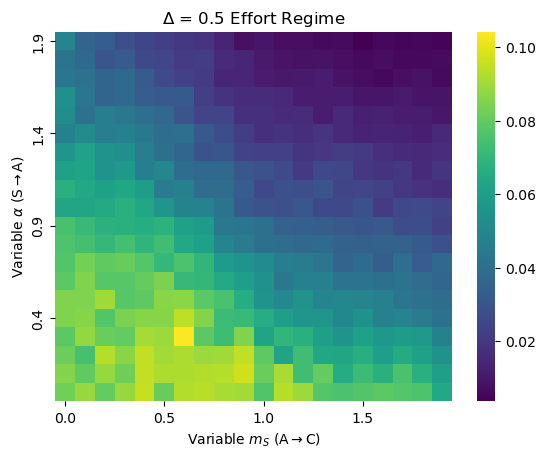

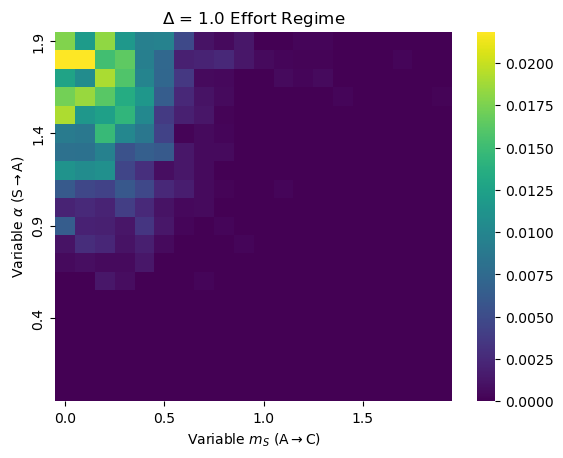

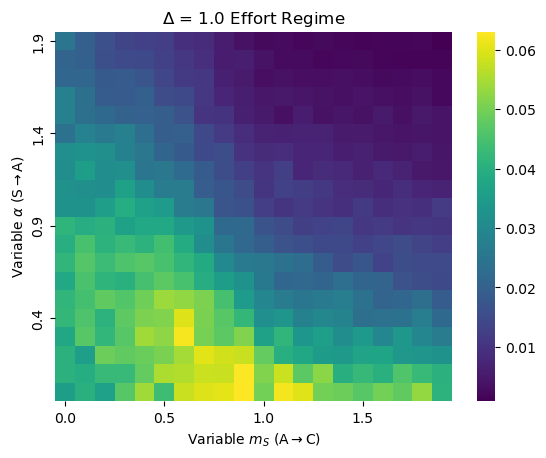

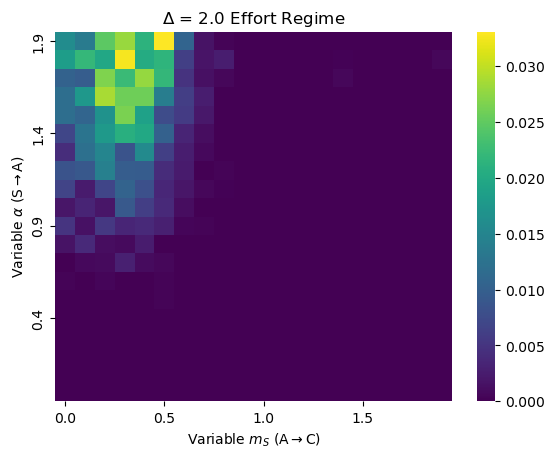

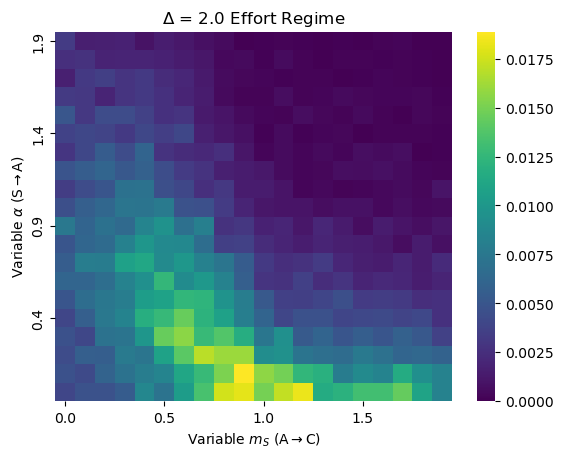

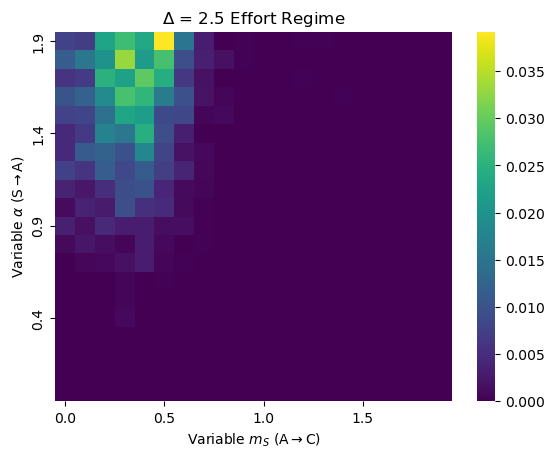

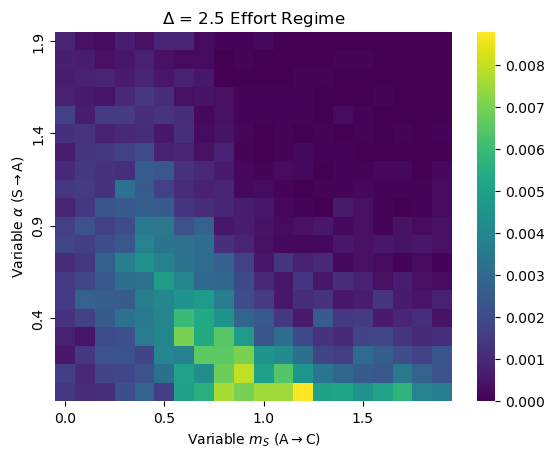

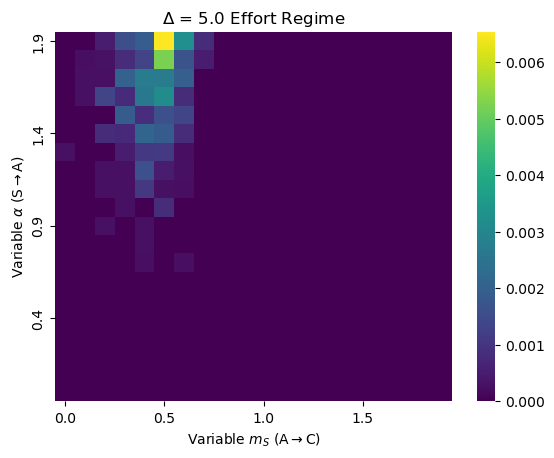

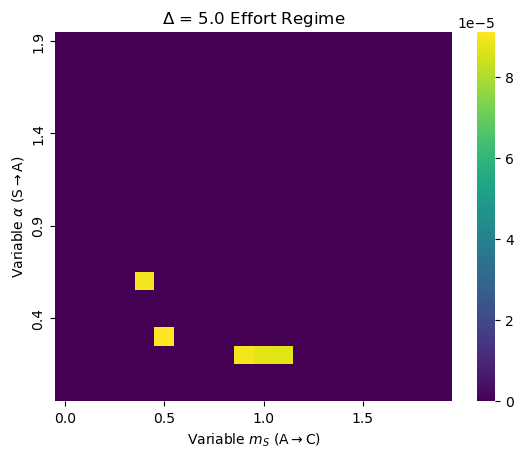

In [737]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["pred_delta_too_high"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_0", delta)
  all_improve_heat_map_effort(ei_data_test["pred_delta_too_high"][d][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Improvement_1", delta)

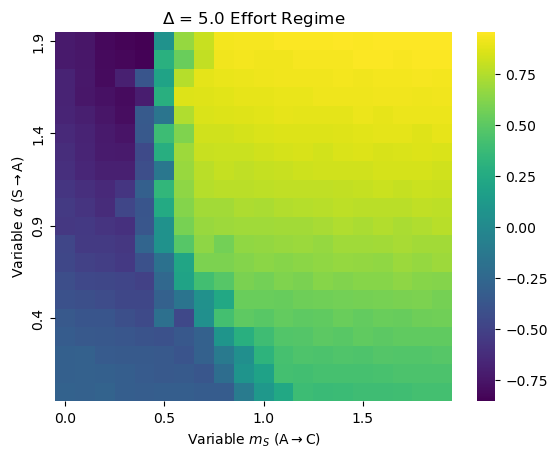

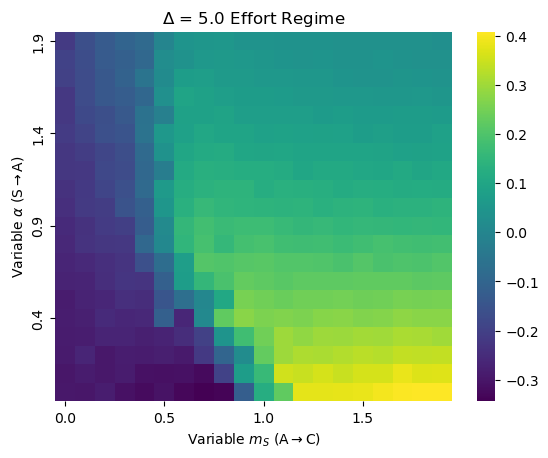

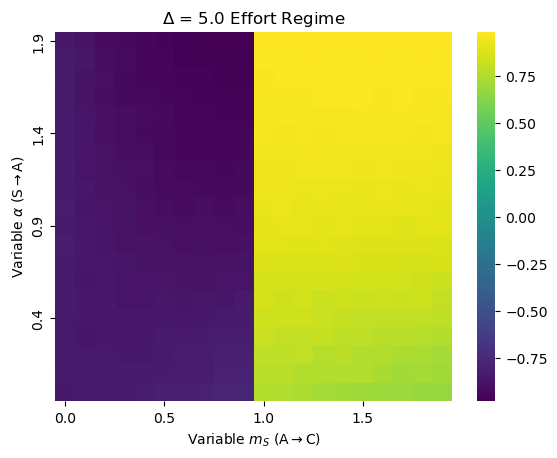

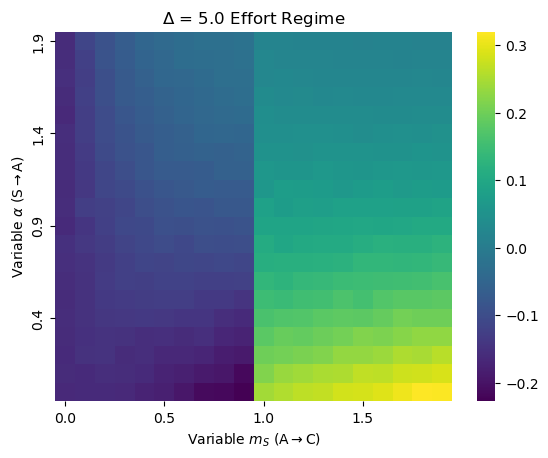

In [732]:
all_improve_heat_map_effort(ei_data_test["pred_feature_improved"][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "pred_feature_improve_0", delta)
all_improve_heat_map_effort(ei_data_test["pred_feature_improved"][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "pred_feature_improve_1", delta)

all_improve_heat_map_effort(ei_data_test["real_feature_improved"][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "real_feature_improve_0", delta)
all_improve_heat_map_effort(ei_data_test["real_feature_improved"][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "real_feature_improve_1", delta)

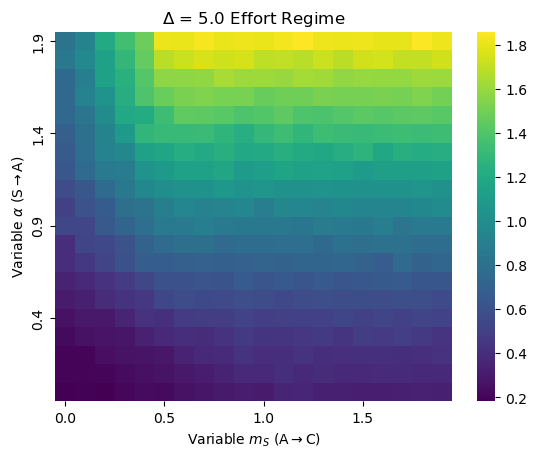

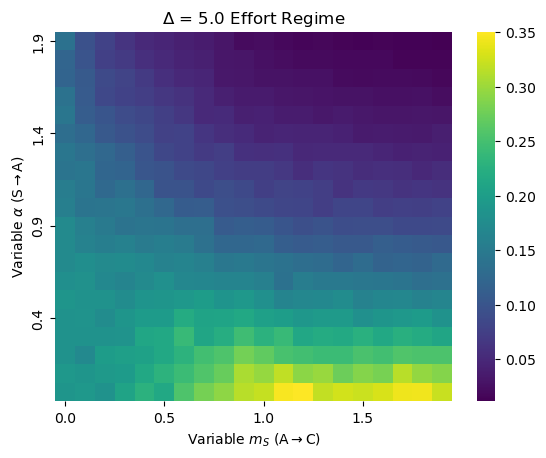

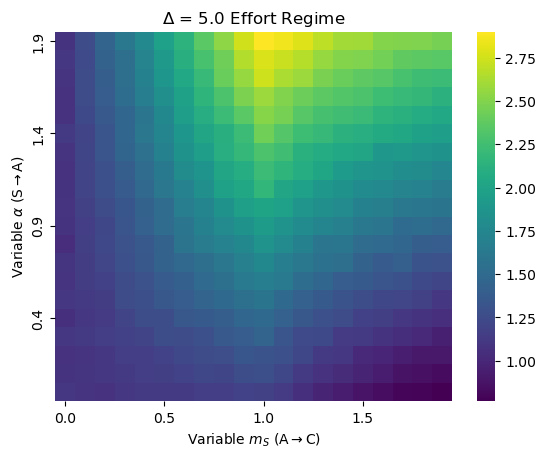

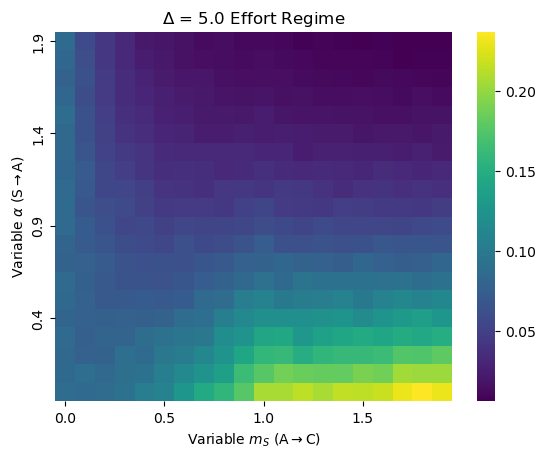

In [733]:
all_improve_heat_map_effort(ei_data_test["pred_delta_improv"][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "pred_delta_0", delta, save=True)
all_improve_heat_map_effort(ei_data_test["pred_delta_improv"][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "pred_delta_1", delta, save=True)

all_improve_heat_map_effort(ei_data_test["real_delta_improv"][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "real_delta_0", delta, save=True)
all_improve_heat_map_effort(ei_data_test["real_delta_improv"][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"], "real_delta_1", delta, save=True)

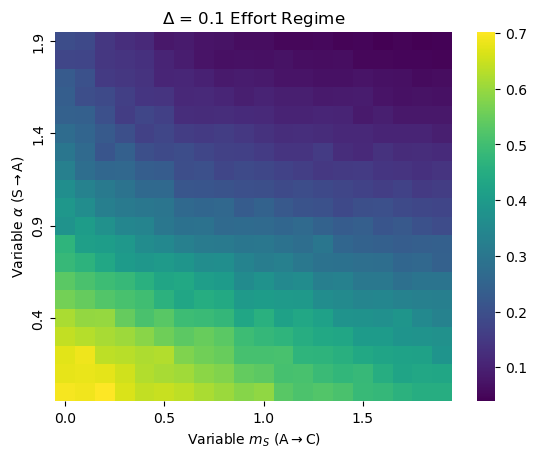

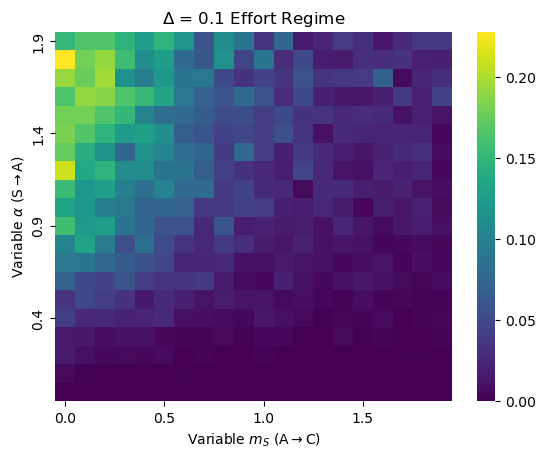

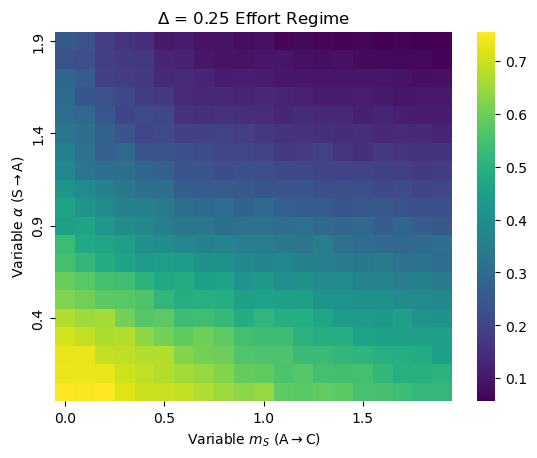

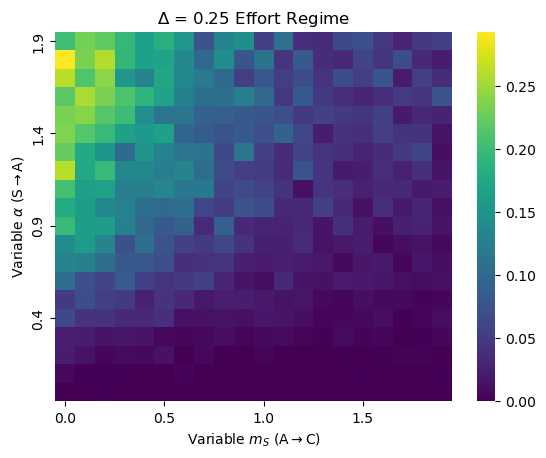

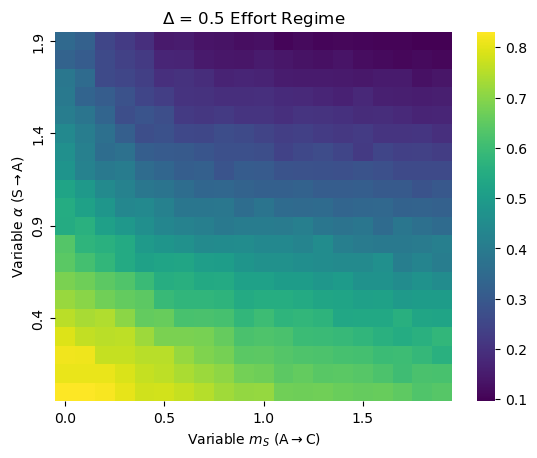

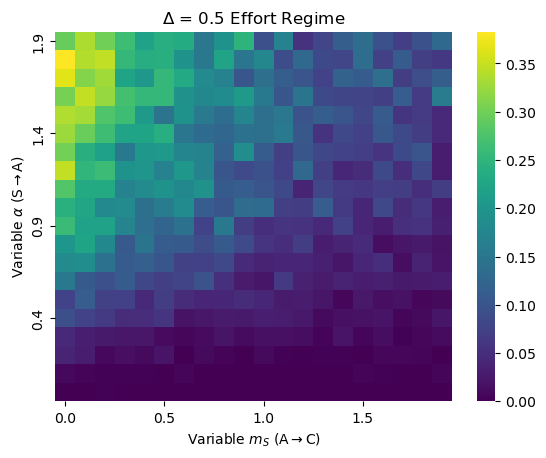

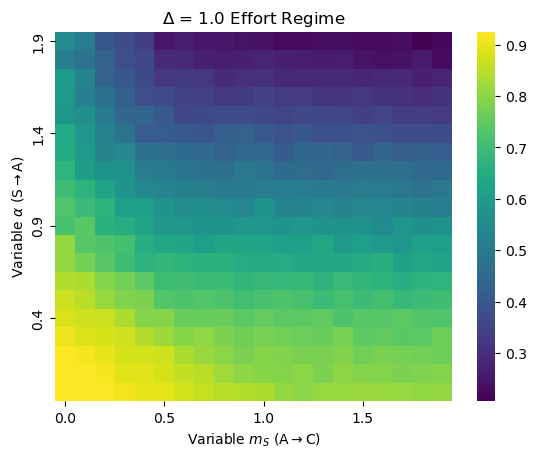

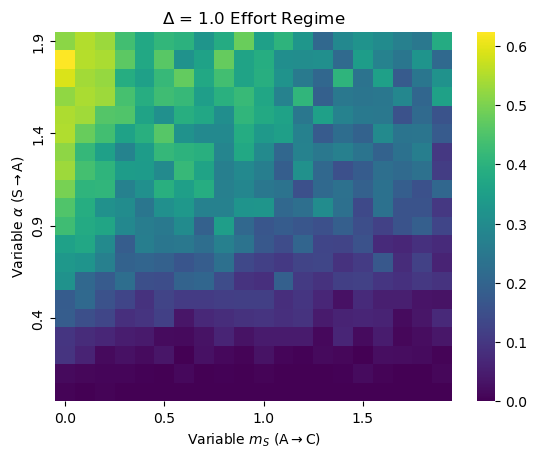

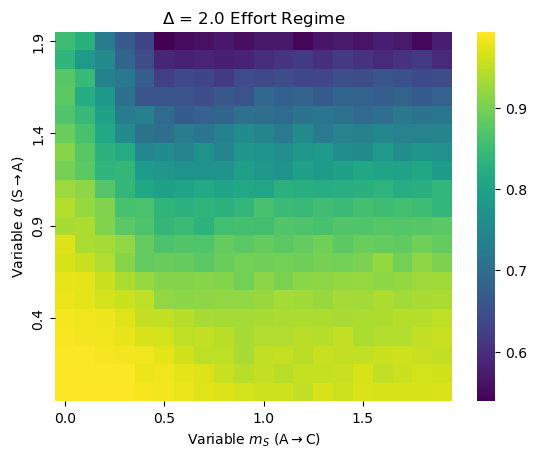

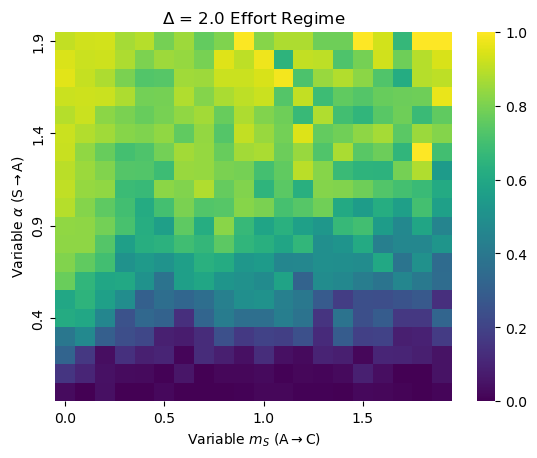

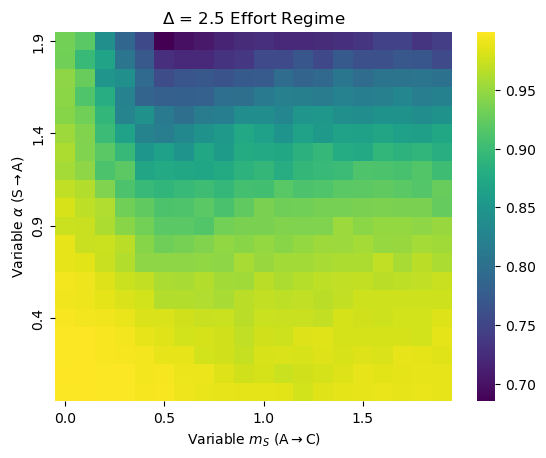

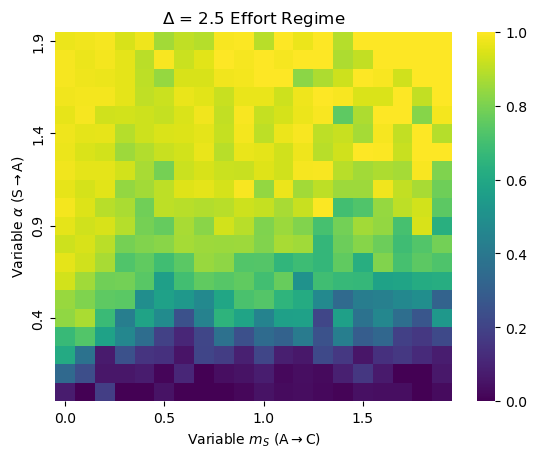

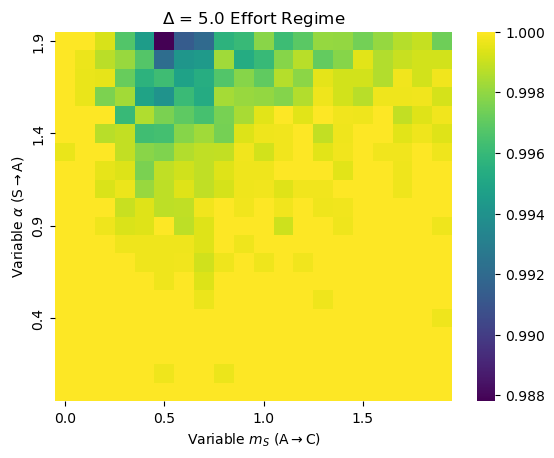

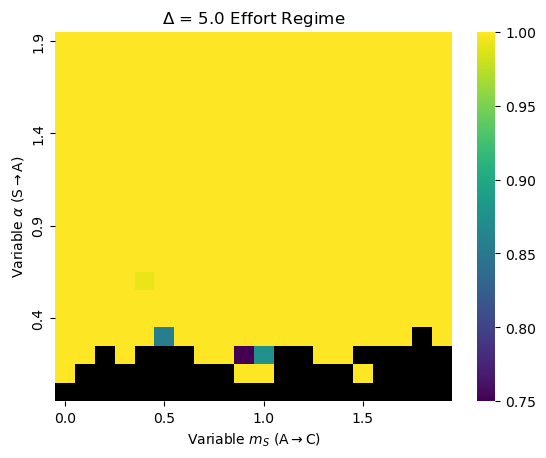

In [734]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["gaming_data"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Gaming_0", delta, save=True)
  all_improve_heat_map_effort(ei_data_test["gaming_data"][d][:,:,1], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Gaming_1", delta, save=True)

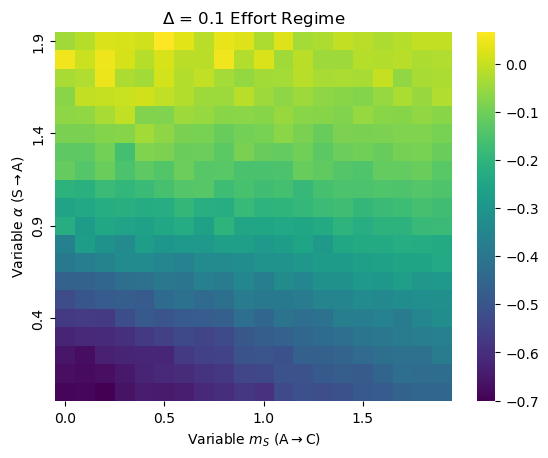

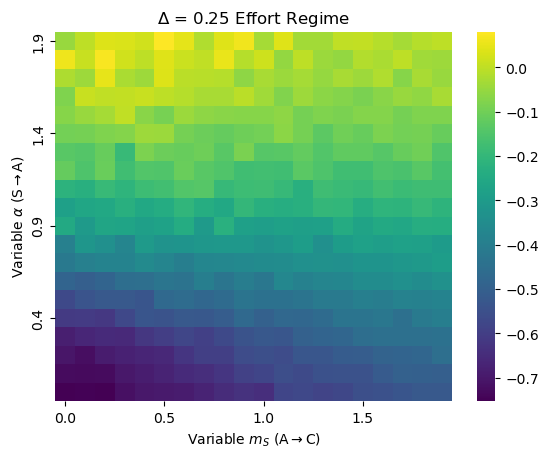

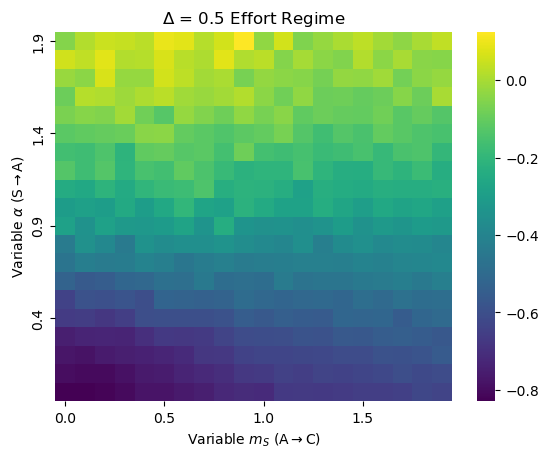

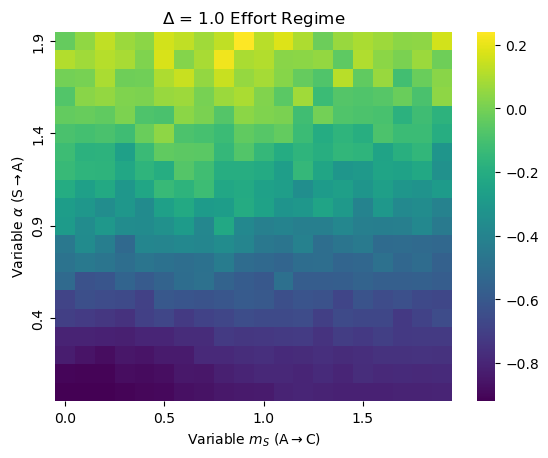

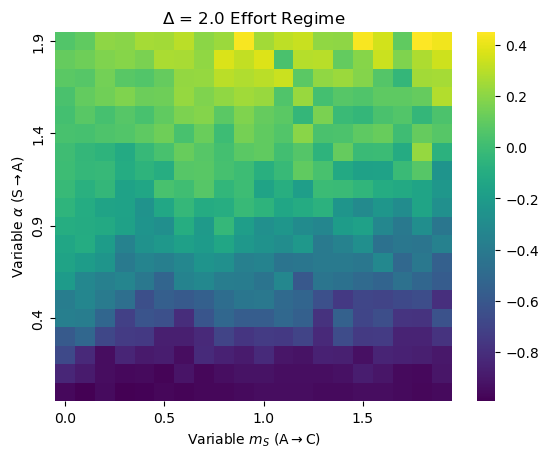

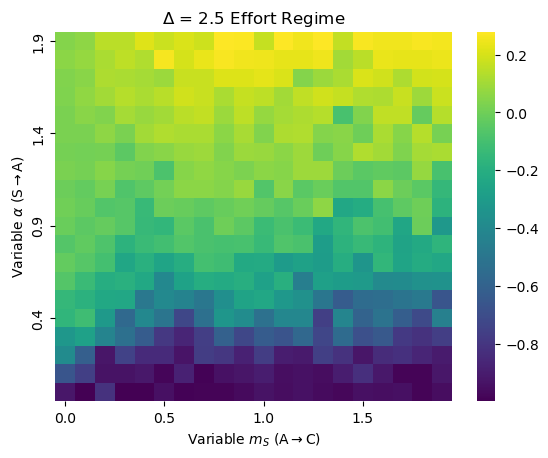

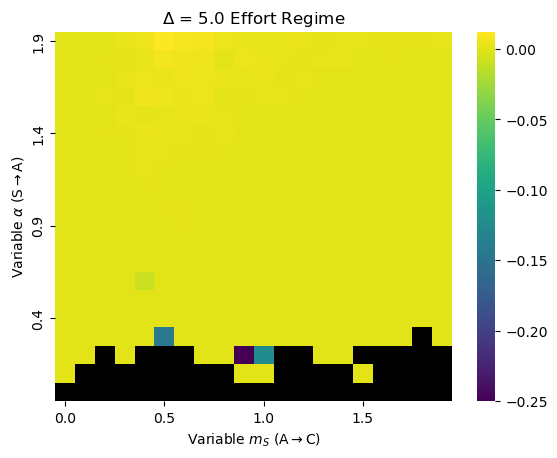

In [735]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["gaming_data"][d][:,:,1] - ei_data_test["gaming_data"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "Gaming_diff", delta, save=True)


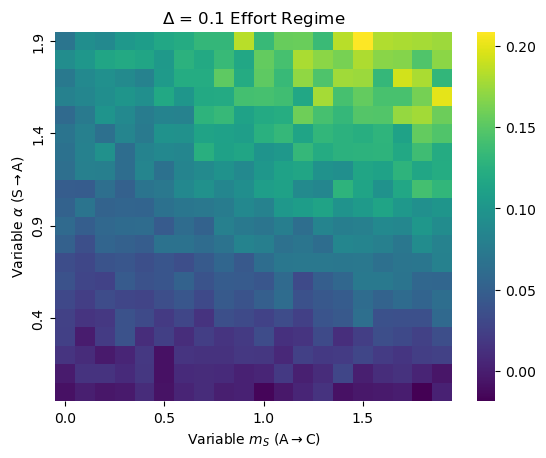

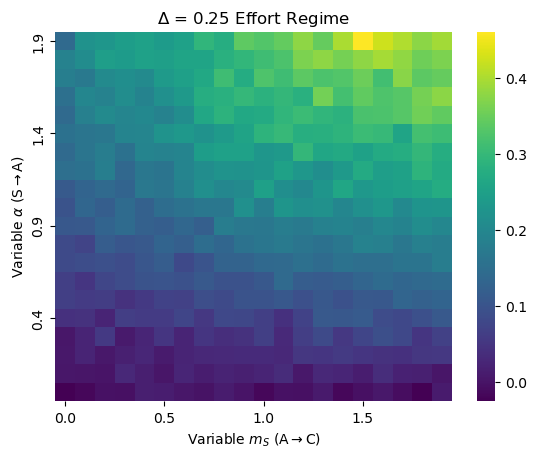

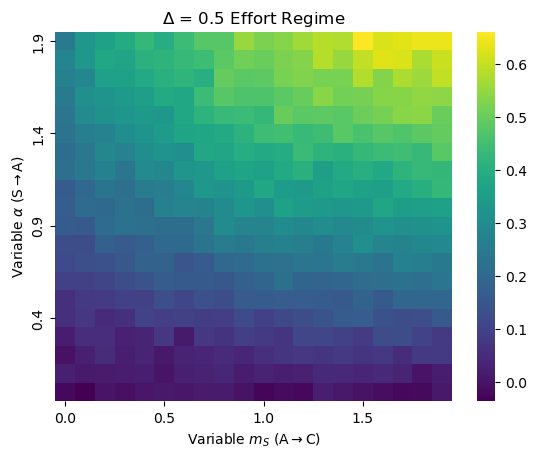

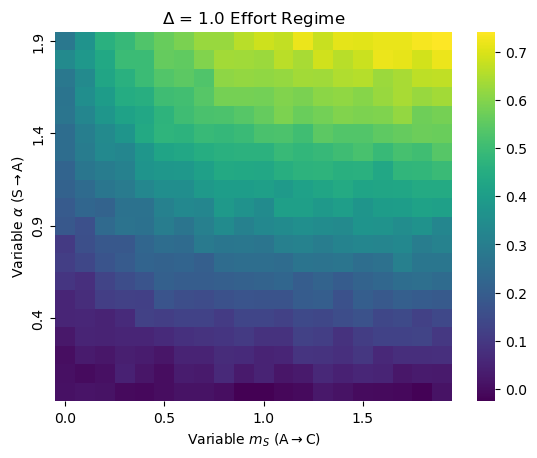

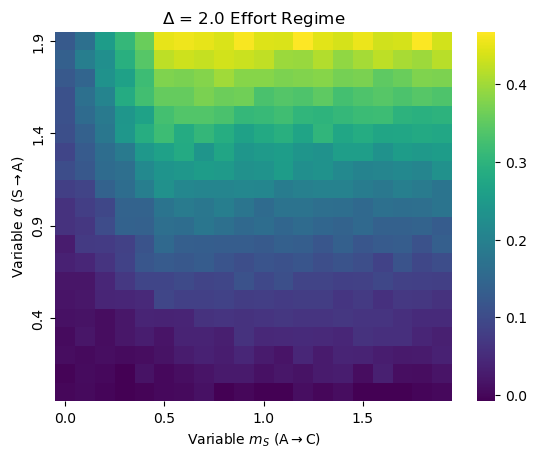

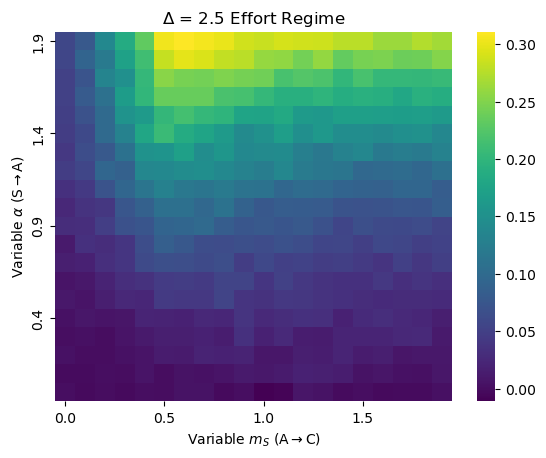

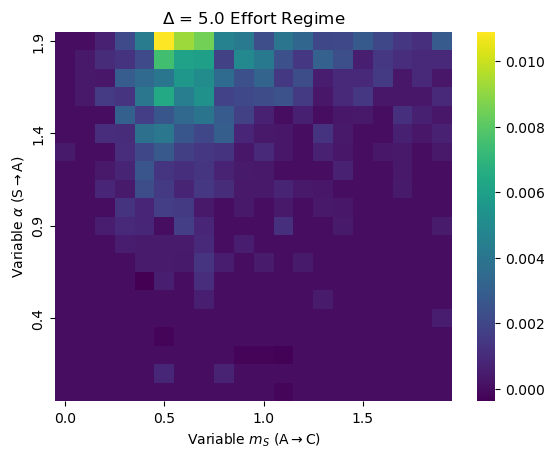

In [736]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  all_improve_heat_map_effort(ei_data_test["ei_data"][d][:,:,1]- ei_data_test["ei_data"][d][:,:,0], 
                              simulation_gaming["consts_sa"], r"$\alpha$ (S$\rightarrow$A)", 
                              simulation_gaming["consts_ac"], r"$m_S$ (A$\rightarrow$C)", 
                              simulation_gaming["type_effort"][d], "SY_TEST_AC", delta)
